In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from os.path import join
from collections import defaultdict

import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
import matplotlib.cm as cm

import seaborn as sns
from tabulate import tabulate

from bgspy.utils import load_pickle, mean_ratio
from bgspy.utils import center_and_scale, coefvar
from bgspy.plots import to_mb, get_figax, predicted_observed, smooth
from bgspy.optim import optim_diagnotics_plot

In [3]:
plt.show()

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'cm'
plt.style.use('./buffalo.mplstyle')

FIGDIR = '../manuscript/figures/'

# from https://writing.stackexchange.com/questions/21658/what-is-the-image-size-in-scientific-paper-if-indicated-as-a-single-1-5-or-2-c 
# in mm
mm_to_inches = lambda x: 0.0393701 * x
img_size = dict(one = mm_to_inches(90), onehalf = mm_to_inches(140), two = mm_to_inches(190))
asp_ratio = dict(golden = (1 + np.sqrt(5))/2, one=1, two=2)
fig_sizes = {(k, ar): np.round((v, v/asp_ratio[ar]), 4) for k, v in img_size.items() for ar in asp_ratio}
fig_sizes

{('one', 'golden'): array([3.5433, 2.1899]),
 ('one', 'one'): array([3.5433, 3.5433]),
 ('one', 'two'): array([3.5433, 1.7717]),
 ('onehalf', 'golden'): array([5.5118, 3.4065]),
 ('onehalf', 'one'): array([5.5118, 5.5118]),
 ('onehalf', 'two'): array([5.5118, 2.7559]),
 ('two', 'golden'): array([7.4803, 4.6231]),
 ('two', 'one'): array([7.4803, 7.4803]),
 ('two', 'two'): array([7.4803, 3.7402])}

# Main Fits Comparisons

There were numerous test fits along the way as the software was being developed, tested, and scaled. 

These however are the main for the paper. Note that the priority matters; early tracks take priority and if they overlap with other tracks, the first feature takes priority.

Checks indicate whether complete:

 - phastcons + CDS + genes
   - LOO: full & sparse 
 - CDS + genes + phastcons
   - LOO: 
 - CADD6
   - LOO: 
 - CADD8
   - LOO: full & sparse~
 
Before inspecting individual models, we want to do basic model comparison with LOO $R^2$.

## Load Models

In [5]:
# how many models?
npops = 3
nannot = 4
nsparse_full = 2
nb_models = 2
npops * nannot * nsparse_full *nb_models 

48

In [6]:
model_names = {
    'phastcons > CDS > genes': 'phastcons_CDS_genes__decode',
    #'phastcons > utrs > genes': 'phastcons_utrs_genes__decode',
    'CDS > genes > phastcons': 'CDS_genes_phastcons__decode',
    'CADD 6%': 'cadd6__decode',
    'CADD 8%': 'cadd8__decode',
}

In [7]:
models = {n: load_pickle(join('../new_fits/', d, d+'.pkl')) for n, d in model_names.items()}

/home/vsb/projects/bprime/bgspy/data.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [8]:
models['CDS > genes > phastcons'].fits[('chb',
  '1000000',
  'sparse')]['mbp'].loo_R2()

0.5648052501941312

In [9]:
def summarize_models(models):
    vals = []

    for model in models.keys():
        for key, model_objs in models[model].fits.items():
            pop, window, fit_type = key
            if int(window) != 1_000_000:
                continue
            mb, mbp = model_objs['mb'], model_objs['mbp']
            mb_mu_se = mb.sigma_[1] if mb.sigma_ is not None else None
            mbp_mu_se = mbp.sigma_[1] if mbp.sigma_ is not None else None            
            vals.append(dict(model=model, pop=pop, window=window, fit_type=fit_type, mb_R2=mb.R2(), 
                             mbp_R2=mbp.R2(), mbp_loo_R2=mbp.loo_R2(), mbp_mu=mbp.mle_mu, mb_mu=mb.mle_mu,
                            mbp_mu_sigma=mbp_mu_se, mb_mu_sigma=mb_mu_se))
    df = pd.DataFrame(vals).sort_values(['model', 'pop', 'fit_type'])

    all_models = df['model'].unique().tolist()
    all_pops = df['pop'].unique().tolist()

    pop_to_num = {pop: num for num, pop in enumerate(['yri', 'ceu', 'chb', ])}
    df['pop_num'] = df['pop'].map(pop_to_num)

    # the model with UTRS is a lot like the others so skip
    df = df.loc[df['model'] != 'phastcons > utrs > genes']
    dfg = df.groupby(['model', 'fit_type']).max('mbp_loo_R2').sort_values('mbp_loo_R2', ascending=False).reset_index()
    dfg['model_num'] = np.arange(dfg.shape[0])

    model_to_num = {model: num for num, model in zip(dfg['model_num'], dfg['model'])}
    df['model_num'] = df['model'].map(model_to_num)
    return df

In [10]:
df = summarize_models(models)

# sorted by R2
dfg = df.groupby(['model', 'fit_type']).max('mbp_loo_R2').sort_values('mbp_loo_R2', ascending=False).reset_index()

# this stuff is used by plots
all_models = df['model'].unique().tolist()
all_pops = df['pop'].unique().tolist() 
pop_to_num = {pop: num for num, pop in enumerate(['yri', 'ceu', 'chb', ])}
model_to_num = {model: num for num, model in zip(dfg['model_num'], dfg['model'])}

## Color Settings

Common population colors. We use paired, since in the $R^2$ plots they are paired.

In [11]:
pop_to_num

{'yri': 0, 'ceu': 1, 'chb': 2}

In [12]:
cmap = cm.get_cmap('Paired')
pop_cols = cmap(np.arange(6))

/tmp/ipykernel_70400/3553568411.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Paired')


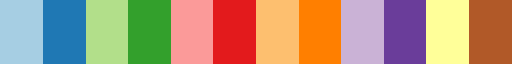

In [13]:
cmap

In [14]:
all_pop_cols = dict()
i = 0
for pop in pop_to_num:
    #plt.scatter(pop, i, c=pop_cols[i+1, :], s=40)
    all_pop_cols[pop] = pop_cols[i+1, :]
    i += 2

## R2 and Model Comparison

### R2 Theoretic Limit Calculation

Some back-of-the-envelope calcs for $R^2$ under coalescent noise.

$$
R^2 = \frac{SS_{reg}}{SS_{reg} + SS_{res}}
$$

Where $SS_{reg}$ is the variance explained by the function (prediction) and $SS_{res}$ is the coalescent noise around this, at the megabase scale.

In [15]:
from bgspy.utils import load_seqlens, bin_chrom
from bgspy.recmap import RecMap
hgsl = load_seqlens('../data/fit_annotation/hg38_seqlens.tsv')
rm = RecMap('../data/fit_annotation/decode_2019_map.txt', hgsl)

In [16]:
# for this section an example fit
fit = models['CADD 6%'].fits[('ceu','100000','sparse')]['mbp']

First, what's the average recombination rate?

In [17]:
from itertools import chain

ave_rec_rates = defaultdict(list)
for chrom, *bin_range in fit.bins.flat_bins():
    bin_range = np.array(bin_range)
    a, b = rm.lookup(chrom, bin_range, cumulative=True)
    ave_rec_rates[chrom].append((b-a) / (bin_range[1] - bin_range[0]))
ave_rec_rates = {c: np.array(v) for c, v in ave_rec_rates.items()}

bin_ave_rec_rates = np.fromiter(chain(*ave_rec_rates.values()), dtype='float')

In [18]:
np.nanmean(bin_ave_rec_rates)

1.3259555716416979e-08

So with mutation rates ~$1.3 \times 10^{-8}$ this is $r/\mu \approx 1$.

In [19]:
pred_pi = fit.predict()
pred_B = fit.predict(B=True)
pi0 = fit.mle_pi0
np.var(pred_pi * 1e6)

25991.071541993828

In [20]:
import scipy.integrate as integrate


def f2(rho):
    return (rho + 18) / (rho**2 + 13*rho + 18)

def varS(theta, rho):
    def func(x):
        return (rho - x)*f2(x)
    try:
        integrand, error = integrate.quad(func, 0, rho, epsabs=1e-11)
    except integrate.IntegrationWarning as e:
        return np.nan
    return theta + theta**2 * (2/rho**2) * integrand

# rho in humans is 1e-3 (r = 1e-8 * 1e4 * 4)
Mb = 1e6
Ne = 10_000
mu = 1e-8
r = 1e-8

# some test calcs
ssres = varS(4 * Ne * mu * Mb, 4 * Ne * r * Mb) 
ssreg = np.var(pred_pi * Mb)

ssreg / (ssres + ssreg)

0.8372506291356913

First, we look at fixed $\mu$ and $r$ that varies in a window. $\mu$ varies too, so this is rough approximation (as all of this is).

In [21]:
mu = 1.3e-8
r2_limit = dict()
for pop in all_pops:
    fit = models['CADD 6%'].fits[(pop, '1000000','sparse')]['mbp']
    pred_pi = fit.predict()
    pred_B = fit.predict(B=True)
    pi0 = fit.mle_pi0
   
    ssres = []
    for i, b in enumerate(pred_B):
        r = bin_ave_rec_rates[i]
        if r == 0:
            continue
        ssres.append(varS(pi0 * b * Mb, pi0 / mu * r * b * Mb))
    ssres = np.nanmedian(ssres)
    ssreg = np.nanvar(pred_pi * Mb)
    r2_limit[pop] = ssreg / (ssres + ssreg)

In [22]:
r2_limit

{'ceu': 0.5277659637102037,
 'chb': 0.5321009375867869,
 'yri': 0.5643691379685886}

These seem extremely conservative. A safer approach is to perhaps fix the recombination rate and vary $r/\mu$ and see how sensitive it is.

In [23]:
r2_model = 'CADD 8%'

r_mu_ratios = np.sort(np.linspace(0.5, 1.5, 10).tolist() + [1])

all_r2_limit_all = defaultdict(dict)
r2_limit_r_mu1_all = defaultdict(dict)

for r2_model in all_models:
    for pop in all_pops:
        fit = models[r2_model].fits[(pop, '1000000','sparse')]['mbp']
        pred_pi = fit.predict()
        pred_B = fit.predict(B=True)
        pi0 = fit.mle_pi0
        r2_limit = []
        for rm_ratio in r_mu_ratios:
            ssres = []
            for b in pred_B:
                ssres.append(varS(pi0 * b * Mb, pi0 * rm_ratio * b * Mb))
            ssres = np.mean(ssres)
            ssreg = np.var(pred_pi * Mb) 
            r2_limit.append(ssreg / (ssres + ssreg))
        all_r2_limit_all[r2_model][pop] = np.array(r2_limit)
        r2_limit_r_mu1_all[r2_model][pop] = all_r2_limit_all[r2_model][pop][r_mu_ratios == 1]

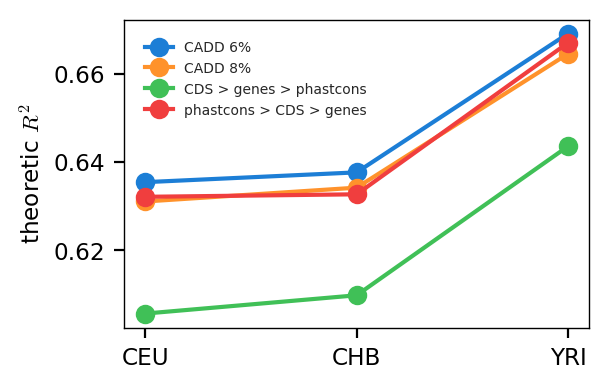

In [24]:
fig, ax = plt.subplots(figsize=(3, 2))
for model, pops in r2_limit_r_mu1_all.items():
    ax.plot([x.upper() for x in pops.keys()], pops.values(), '-o', label=model)
ax.set_ylabel('theoretic $R^2$')
ax.legend(fontsize=5)

The major variability is across the populations, not models. So we choose CADD 6% without loss of generality.

In [25]:
best_model = 'CADD 6%'
all_r2_limit, r2_limit_r_mu1 = all_r2_limit_all[best_model], r2_limit_r_mu1_all[best_model] 

In [26]:
all_r2_limit, r2_limit_r_mu1

({'ceu': array([0.50249507, 0.54193866, 0.57439639, 0.60167097, 0.62497255,
         0.63540887, 0.64514988, 0.66281892, 0.67843925, 0.69236171,
         0.70485939]),
  'chb': array([0.50529308, 0.54459401, 0.57691539, 0.60406285, 0.6272472 ,
         0.63762854, 0.64731688, 0.66488715, 0.68041681, 0.6942559 ,
         0.70667675]),
  'yri': array([0.53787187, 0.57737953, 0.6095303 , 0.63629662, 0.65898343,
         0.66909056, 0.6784943 , 0.69547766, 0.71041256, 0.72366147,
         0.73550426])},
 {'ceu': array([0.63540887]),
  'chb': array([0.63762854]),
  'yri': array([0.66909056])})

/tmp/ipykernel_70400/1855157659.py:8: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(1, r2_lim, c=lines[0].get_color(), zorder=2)


Text(0.5, 0, 'ratio of recombination to mutation rates')

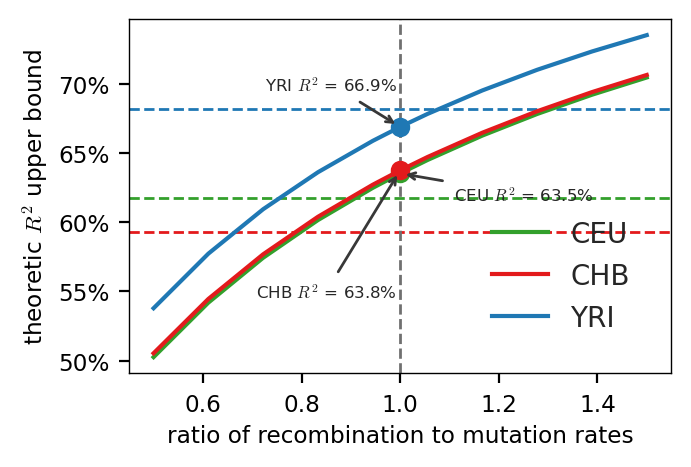

In [27]:
text_coords = dict(chb=(0.85, 0.55), ceu=(1.25, 0.62), yri=(0.86, 0.7))

fig, ax = plt.subplots(figsize=(3.5,2.3))
ax.axvline(1, linewidth=1, linestyle='dashed', c='0.44', zorder=-1)
for pop in all_pops:
    lines = ax.plot(r_mu_ratios, all_r2_limit[pop], label=pop.upper(), c=all_pop_cols[pop])
    r2_lim = all_r2_limit[pop][r_mu_ratios == 1]
    ax.scatter(1, r2_lim, c=lines[0].get_color(), zorder=2)
    ax.annotate(f"{pop.upper()} $R^2$ = {np.round(100*r2_lim[0], 1)}%", (1, r2_lim), xytext=text_coords[pop],
                va='center', ha='center', 
                arrowprops=dict(arrowstyle='->', color='0.22'), fontsize=6)
    
    dfx = df.loc[(df['fit_type'] == 'full') & (df['pop'] == pop) & (df['model'] == 'phastcons > CDS > genes')]
    ax.axhline(dfx['mbp_loo_R2'].tolist()[0], c=lines[0].get_color(), linestyle='dashed', linewidth=1, zorder=-10)

ax.legend()
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, decimals=0))
ax.set_ylabel('theoretic $R^2$ upper bound')
#ax.set_xlabel('ratio of recombination to mutation rates, $\gamma$')
ax.set_xlabel('ratio of recombination to mutation rates')
#plt.savefig('../manuscript/figures/supplementary/suppfigure_R2_upper.pdf', bbox_inches='tight')

### Rough StdPopSim Simulation Approximation

We can't do varying $N_e$ along the chromosome, but we can look roughly at how mean and variance diversity scale across populations.

In [28]:
import stdpopsim

species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("OutOfAfrica_3G09")

In [29]:
contig = species.get_contig("chr2")
contig = species.get_contig("chr2", mutation_rate=model.mutation_rate)

samples = {"YRI": 5, "CHB": 5, "CEU": 5}
engine = stdpopsim.get_engine("msprime")
ts = engine.simulate(model, contig, samples)

In [30]:
sample_ids = {pop: ts.samples(population=i) for i, pop in enumerate(samples)}
sample_ids

{'YRI': array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 'CHB': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], dtype=int32),
 'CEU': array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29], dtype=int32)}

In [31]:
Mb_bins = bin_chrom(ts.sequence_length, 1_000_000)
div_stats = {}
for pop in all_pops:
    ids = sample_ids[pop.upper()]
    pi = ts.diversity(windows=Mb_bins, sample_sets=ids)
    #pi = ts.diversity(sample_sets=ids)
    m = np.mean(pi)
    v = np.var(pi)
    div_stats[pop] = m, v

/tmp/ipykernel_70400/2546653706.py:4: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(m, v, label=pop, s=50, c=all_pop_cols[pop])


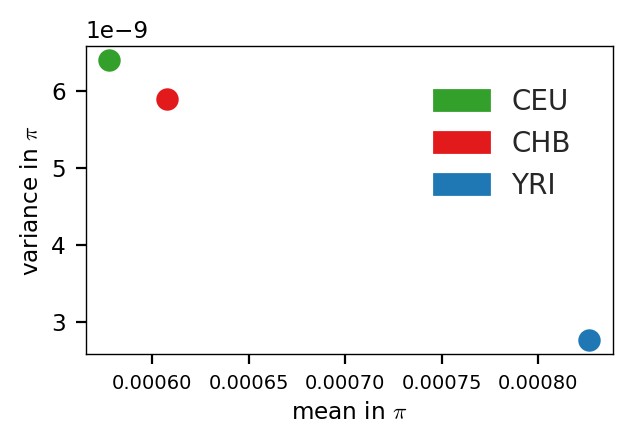

In [32]:
fig, ax = plt.subplots(figsize=(3.4,2))
i = 0
for pop, (m, v) in div_stats.items():
    ax.scatter(m, v, label=pop, s=50, c=all_pop_cols[pop])
    i +=2
ax.tick_params(axis='x', labelsize=7)
ax.legend()
ax.set_ylabel("variance in $\pi$")
ax.set_xlabel("mean in $\pi$")

legend_elements = [mpatches.Patch(color=handle.get_facecolor(), label=pop.upper()) for handle, pop in zip(ax.collections, div_stats.keys())]
ax.legend(handles=legend_elements)


So this is interesting, but not unexpected: typically we would expect larger $N_e$ leads to larger variance in coalescence times, since $\mathrm{V}(\pi) = \frac{2\theta^2}{9}$ (Tajima, 1983). However, the bottlenecks increase the variance in pairwise diversity, rather than decrease it. What does this mean for $R^2$?

The bottlenecked populations have much higher variance in $\pi$ across windows. This implies that the $SS_\text{res}$ should be higher, leading to a *lower* $R^2$ than our simple approximation would have.

### LaTeX table

In [33]:
r2_table = df.sort_values('mbp_loo_R2', ascending=False).reset_index()[['model', 'fit_type', 'pop', 'mbp_loo_R2', 'mbp_R2', 'mb_R2', 'mbp_mu', 'mb_mu']]

In [34]:
# no rounding; here fo posterity
r2_table

,model,fit_type,pop,mbp_loo_R2,mbp_R2,mb_R2,mbp_mu,mb_mu
0,phastcons > CDS > genes,sparse,yri,0.684462,0.681582,0.652282,1.863582e-08,2.974909e-09
1,phastcons > CDS > genes,full,yri,0.681947,0.681177,0.636663,1.708202e-08,1.665730e-09
2,CADD 6%,full,yri,0.680751,0.680839,0.629597,1.461169e-08,1.720629e-09
3,CADD 6%,sparse,yri,0.680414,0.680280,0.680109,2.091161e-08,2.071645e-08
4,CADD 8%,full,yri,0.669835,0.671076,0.636074,1.012636e-08,1.712718e-09
5,CADD 8%,sparse,yri,0.666718,0.670084,0.669809,1.568793e-08,1.547318e-08
6,CDS > genes > phastcons,full,yri,0.649049,0.655097,0.612346,4.195132e-08,1.619832e-09
7,CDS > genes > phastcons,sparse,yri,0.649049,0.655099,0.631643,4.179467e-08,3.069820e-09
8,phastcons > CDS > genes,sparse,ceu,0.619834,0.630152,0.600197,2.019394e-08,3.035946e-09
9,phastcons > CDS > genes,full,ceu,0.617759,0.630106,0.585749,2.349873e-08,1.678860e-09


In [35]:
r2_table['mb_R2'] = np.round(100*r2_table['mb_R2'], 2)
r2_table['mbp_R2'] = np.round(100*r2_table['mbp_R2'], 2)
r2_table['mbp_loo_R2'] = np.round(100*r2_table['mbp_loo_R2'], 2)
r2_table['mbp_mu'] = np.round(r2_table['mbp_mu'] * 1e8, 4)
r2_table['mb_mu'] = np.round(r2_table['mb_mu'] * 1e8, 4)
r2_table['pop'] = [x.upper() for x in r2_table['pop']]
r2_table['model'] = [x.replace(' > ', '$>$').replace('%', '\%') for x in r2_table['model']]
r2_table

,model,fit_type,pop,mbp_loo_R2,mbp_R2,mb_R2,mbp_mu,mb_mu
0,phastcons$>$CDS$>$genes,sparse,YRI,68.45,68.16,65.23,1.8636,0.2975
1,phastcons$>$CDS$>$genes,full,YRI,68.19,68.12,63.67,1.7082,0.1666
2,CADD 6\%,full,YRI,68.08,68.08,62.96,1.4612,0.1721
3,CADD 6\%,sparse,YRI,68.04,68.03,68.01,2.0912,2.0716
4,CADD 8\%,full,YRI,66.98,67.11,63.61,1.0126,0.1713
5,CADD 8\%,sparse,YRI,66.67,67.01,66.98,1.5688,1.5473
6,CDS$>$genes$>$phastcons,full,YRI,64.90,65.51,61.23,4.1951,0.1620
7,CDS$>$genes$>$phastcons,sparse,YRI,64.90,65.51,63.16,4.1795,0.3070
8,phastcons$>$CDS$>$genes,sparse,CEU,61.98,63.02,60.02,2.0194,0.3036
9,phastcons$>$CDS$>$genes,full,CEU,61.78,63.01,58.57,2.3499,0.1679


In [36]:
new_header = {'model': '\\textbf{model}',
              'fit_type': '\\textbf{fit type}', 
              'pop': '\\textbf{pop}', 
              'mbp_loo_R2': "\\textbf{out-sample B' $R^2$}", 
              'mbp_R2':"\\textbf{B' $R^2$}", 
              'mb_R2':"\\textbf{B $R^2$}", 
              'mbp_mu':"\\textbf{B' $\hat{\mu} \\times 10^{-8}$}",
              'mb_mu': "\\textbf{B $\hat{\mu} \\times 10^{-8}$}"}
header = [new_header.get(h, h) for h in r2_table.columns]
print(r2_table.to_latex(index=False, header=header, escape=False, caption='$R^2$ and mutation rate estimates for all models'))

\begin{table}
\centering
\caption{$R^2$ and mutation rate estimates for all models}
\begin{tabular}{lllrrrrr}
\toprule
         \textbf{model} & \textbf{fit type} & \textbf{pop} & \textbf{out-sample B' $R^2$} & \textbf{B' $R^2$} & \textbf{B $R^2$} & \textbf{B' $\hat{\mu} \times 10^{-8}$} & \textbf{B $\hat{\mu} \times 10^{-8}$} \\
\midrule
phastcons$>$CDS$>$genes &            sparse &          YRI &                        68.45 &             68.16 &            65.23 &                                 1.8636 &                                0.2975 \\
phastcons$>$CDS$>$genes &              full &          YRI &                        68.19 &             68.12 &            63.67 &                                 1.7082 &                                0.1666 \\
               CADD 6\% &              full &          YRI &                        68.08 &             68.08 &            62.96 &                                 1.4612 &                                0.1721 \\
               CADD 

/tmp/ipykernel_70400/3403385105.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(r2_table.to_latex(index=False, header=header, escape=False, caption='$R^2$ and mutation rate estimates for all models'))


### Figure Code

In [37]:
model_to_num

{'phastcons > CDS > genes': 1,
 'CADD 6%': 3,
 'CADD 8%': 5,
 'CDS > genes > phastcons': 7}

In [38]:
alternate_names = {'phastcons > CDS > genes': '\n(PhastCons Priority)', 'CDS > genes > phastcons': '\n(Feature Priority)'}

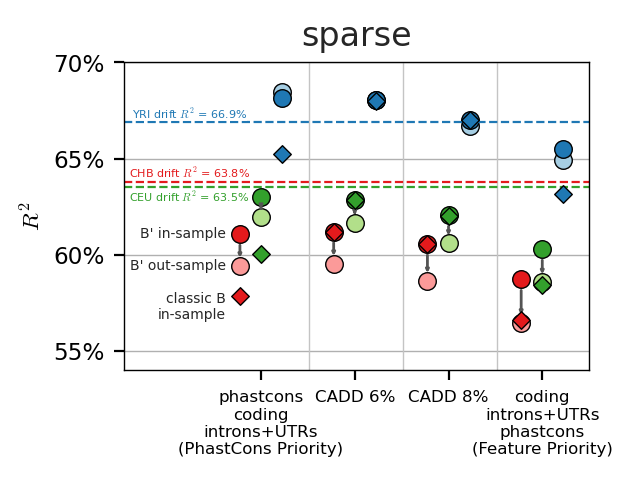

In [39]:
fit_type = 'sparse'

fig, ax = plt.subplots(figsize=(3, 2))

ms = 40
offset = 0.45
center = len(all_pops) / 2

x_min = 1000
i = 0
res = []
for pop in pop_to_num.keys():
    ci = i*2
    dfx = df.loc[(df['fit_type'] == fit_type) & (df['pop'] == pop)]
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_loo_R2'], color=pop_cols[ci, :], s=ms, linewidths=0.5, edgecolors='k')
    scatter = ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_R2'], color=pop_cols[ci+1, :], label=pop.upper(), s=ms, linewidths=0.5, edgecolors='k')
    res.append(scatter)
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mb_R2'], marker="D", linewidths=0.5, color=pop_cols[ci+1, :], 
               edgecolors='k', zorder=100, s=0.5*ms)
    
    i += 1

    x_start = (dfx['model_num'] - offset*(dfx['pop_num'] - center)).tolist()
    x_end = x_start
    y_start = dfx['mbp_R2'].tolist()
    y_end = dfx['mbp_loo_R2'].tolist()

    coordsA = "data"
    coordsB = "data"

    for j in range(len(x_start)):
        if pop == 'yri':
            # omit arrows
            continue
        pop == 'yri' and dfx['model'].tolist()[j] != 'CDS > genes > phastcons'
        con = ConnectionPatch((x_start[j], y_start[j]), (x_end[j], y_end[j]), "data", "data",
                              arrowstyle="->", 
                              shrinkA=4, shrinkB=2.8,
                              mutation_scale=2, fc="0.33", ec='0.33')
        if x_min > x_start[j]:
            in_sample = (x_start[j], y_start[j])
            out_sample = (x_end[j], y_end[j])
            first = x_min = x_start[j]
        ax.add_artist(con)
     
ax.set_xticks(np.array(list(model_to_num.values())) + offset/2)
ax.set_xticklabels([x.replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') + 
                    alternate_names.get(x, "") for x in model_to_num.keys()], fontsize=6)
#ax.set_xticklabels([alternate_names.get(x, x) for x in model_to_num.keys()], fontsize=6)
ax.set_xlim(-1, ax.get_xlim()[1] + 0.2)

def format_func(value, tick_number):
    return "%.f%%" % (value * 100)

fs = 5
sp = 0.3
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_func))
ax.annotate("B' out-sample", out_sample, (out_sample[0]-sp, out_sample[1]), 
            ha='right', va='center',
           fontsize=fs)

ax.annotate("B' in-sample", in_sample, (in_sample[0]-sp, in_sample[1]),
            ha='right',va='center',
           fontsize=fs)

dfx = df.loc[(df['fit_type'] == 'sparse') & (df['pop'] == pop) & (df['model'] == "phastcons > CDS > genes")]
ax.annotate("classic B\nin-sample", (out_sample[0]-sp, 0.573),
            ha='right', va='center',
           fontsize=fs)
ax.set_ylabel("$R^2$")

patches = []
populations = list(pop_to_num.keys())
for i in range(0, len(pop_cols), 2):
    #patches.append((mpatches.Patch(color=pop_cols[i+1, :], label=f'{populations[i//2].upper()}')))
    patch1 = mpatches.Patch(color=pop_cols[i+1, :])
    patch2 = mpatches.Patch(color=pop_cols[i, :])
    patches.append((patch1, patch2))

sep_lines = np.arange(2.25, 10, 2)
for i in sep_lines:
    ax.axvline(i, linestyle='solid', linewidth=0.5, c='0.77')
from matplotlib.legend_handler import HandlerTuple
#legend = ax.legend(loc=(0.005, 0.52), fontsize=6, title='population', title_fontsize=7, 
#                    handles=patches, labels=[x.upper() for x in populations], handler_map={tuple: HandlerTuple(ndivide=2, pad=0.3)})
ax.set_xlim(-1.7, None)

offsets = dict(chb=0.009, ceu=-0.001, yri=0.008)
for pop in pop_to_num:
    limit = r2_limit_r_mu1[pop]
    ax.axhline(limit, linestyle='dashed',
               c=all_pop_cols[pop],
               #c='0.44',
               linewidth=0.8)
    
    t = ax.annotate(f"{pop.upper()} drift $R^2$ = {np.round(100*limit[0], 1)}%", (-0.3, limit+offsets.get(pop, 0)), fontsize=4, va='top', ha='center', c=all_pop_cols[pop])
    t.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0, pad=0))

t = ax.annotate("approximate $R^2$ upper bound for YRI", (5, .742), fontsize=5, va='top', ha='center')
t.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0, pad=0))
ax.yaxis.grid(True, linewidth=0.5)
ax.set_axisbelow(True)
ax.set_ylim((0.54, 0.70))
ax.set_title('sparse')
plt.savefig('../manuscript/figures/figure_2_R2_sparse.pdf', bbox_inches='tight')

/tmp/ipykernel_70400/323813.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Paired')


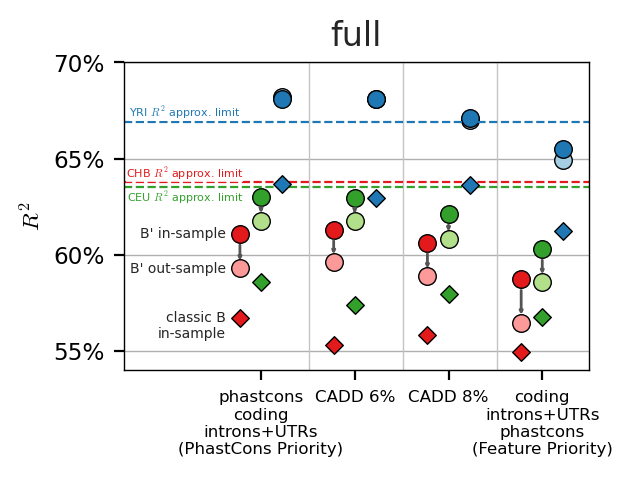

In [40]:
fit_type = 'full'

cmap = cm.get_cmap('Paired')
pop_cols = cmap(np.arange(6))

fig, ax = plt.subplots(figsize=(3, 2))

ms = 40
offset = 0.45
center = len(all_pops) / 2

x_min = 1000
i = 0
res = []
for pop in pop_to_num.keys():
    ci = i*2
    dfx = df.loc[(df['fit_type'] == fit_type) & (df['pop'] == pop)]
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_loo_R2'], color=pop_cols[ci, :], s=ms, linewidths=0.5, edgecolors='k')
    scatter = ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_R2'], color=pop_cols[ci+1, :], label=pop.upper(), s=ms, linewidths=0.5, edgecolors='k')
    res.append(scatter)
    ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mb_R2'], marker="D", linewidths=0.5, color=pop_cols[ci+1, :], 
               edgecolors='k', zorder=100, s=0.5*ms)
    
    i += 1

    x_start = (dfx['model_num'] - offset*(dfx['pop_num'] - center)).tolist()
    x_end = x_start
    y_start = dfx['mbp_R2'].tolist()
    y_end = dfx['mbp_loo_R2'].tolist()

    coordsA = "data"
    coordsB = "data"

    for j in range(len(x_start)):
        if pop == 'yri':
            # omit arrows
            continue
        pop == 'yri' and dfx['model'].tolist()[j] != 'CDS > genes > phastcons'
        con = ConnectionPatch((x_start[j], y_start[j]), (x_end[j], y_end[j]), "data", "data",
                              arrowstyle="->", 
                              shrinkA=4, shrinkB=2.8,
                              mutation_scale=2, fc="0.33", ec='0.33')
        if x_min > x_start[j]:
            in_sample = (x_start[j], y_start[j])
            out_sample = (x_end[j], y_end[j])
            first = x_min = x_start[j]
        ax.add_artist(con)
     
ax.set_xticks(np.array(list(model_to_num.values())) + offset/2)
#ax.set_xticklabels([x.replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in model_to_num.keys()], fontsize=6)
ax.set_xticklabels([x.replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') + 
                    alternate_names.get(x, "") for x in model_to_num.keys()], fontsize=6)
ax.set_xlim(-1, ax.get_xlim()[1] + 0.2)

def format_func(value, tick_number):
    return "%.f%%" % (value * 100)

fs = 5
sp = 0.3
ax.yaxis.set_major_formatter(mtick.FuncFormatter(format_func))
ax.annotate("B' out-sample", out_sample, (out_sample[0]-sp, out_sample[1]), 
            ha='right', va='center',
           fontsize=fs)

ax.annotate("B' in-sample", in_sample, (in_sample[0]-sp, in_sample[1]),
            ha='right',va='center',
           fontsize=fs)

dfx = df.loc[(df['fit_type'] == 'sparse') & (df['pop'] == pop) & (df['model'] == "phastcons > CDS > genes")]
ax.annotate("classic B\nin-sample", (out_sample[0]-sp, 0.563),
            ha='right',va='center',
           fontsize=fs)
ax.set_ylabel("$R^2$")


patches = []
populations = list(pop_to_num.keys())
for i in range(0, len(pop_cols), 2):
    #patches.append((mpatches.Patch(color=pop_cols[i+1, :], label=f'{populations[i//2].upper()}')))
    patch1 = mpatches.Patch(color=pop_cols[i+1, :])
    patch2 = mpatches.Patch(color=pop_cols[i, :])
    patches.append((patch1, patch2))

sep_lines = np.arange(2.25, 10, 2)
for i in sep_lines:
    ax.axvline(i, linestyle='solid', linewidth=0.5, c='0.77')
from matplotlib.legend_handler import HandlerTuple
#legend = ax.legend(loc=(0.005, 0.52), fontsize=6, title='population', title_fontsize=7, 
#                    handles=patches, labels=[x.upper() for x in populations], handler_map={tuple: HandlerTuple(ndivide=2, pad=0.3)})
#legend = fig.legend(loc=(0.825, 0.52), fontsize=6, title='population', title_fontsize=7, 
#                    handles=patches, labels=[x.upper() for x in populations], handler_map={tuple: HandlerTuple(ndivide=2, pad=0.3)})
ax.set_xlim(-1.7, None)

offsets = dict(chb=0.009, ceu=-0.001, yri=0.009)
for pop in all_pops:
    limit = r2_limit_r_mu1[pop]
    ax.axhline(limit, linestyle='dashed',
               c=all_pop_cols[pop],
               #c='0.44',
               linewidth=0.8)
    
    t = ax.annotate(f"{pop.upper()} $R^2$ approx. limit", (-0.4, limit+offsets.get(pop, 0)), fontsize=4, va='top', ha='center', c=all_pop_cols[pop])
    t.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0, pad=0))

ax.yaxis.grid(True, linewidth=0.5)
ax.set_axisbelow(True)
ax.set_ylim((0.54, 0.70))
ax.set_title('full')
plt.savefig('../manuscript/figures/figure_2_R2_full.pdf', bbox_inches='tight')

## All Models

### CADD 6% in 1Mb and 100kb

In [41]:
# 1Mbp
models['CADD 6%'].fits[('yri', '1000000', 'sparse')]

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250663359423.69537
 number of successful starts: 20000 (100.0% total)
 π0 = 0.00142208
 π  = 0.00106447
 μ_del  = 2.072e-08 
 Ne = 35,552 (if μ=1e-8), Ne = 17,776 (if μ=2e-8)
 R² = 68.0109% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.031
 0.001     0.306
 0.01      0.031
 0.1       0.632,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-

Some main points: Looking at B and B' fits below, we see that the B' model allows for the DFE weaker selection, and compensates with higher mutation rate.

In [42]:
# 100kb
models['CADD 6%'].fits[('yri', '100000', 'sparse')]

{'mb': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 100.0 kbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250622462847.73962
 number of successful starts: 20000 (100.0% total)
 π0 = 0.00142721
 π  = 0.00106332
 μ_del  = 1.876e-08 
 Ne = 35,680 (if μ=1e-8), Ne = 17,840 (if μ=2e-8)
 R² = 53.8933% (in-sample)
 W = 
           cadd6
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0.003
 0.0001    0.103
 0.001     0.252
 0.01      0.019
 0.1       0.623,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 100.0 kbp
 
 ML estimates: (whole genome)
 standard error method: None
 negat

In [43]:
# 1Mbp
models['CADD 6%'].fits[('yri', '1000000', 'full')]

{'mb': SimplexModel (interpolated w): 6 x 8 x 2
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250697358180.83066
 number of successful starts: 20000 (100.0% total)
 π0 = 0.00153098
 π  = 0.00106447
 μ_del  = 1.721e-09 
 Ne = 38,274 (if μ=1e-8), Ne = 19,137 (if μ=2e-8)
 R² = 62.9597% (in-sample)
 W = 
           cadd6    other
 ------  -------  -------
 1e-08      0       0
 1e-07      0       0
 1e-06      0       0
 1e-05      0.04    0
 0.0001     0.96    0
 0.001      0       0.006
 0.01       0       0.075
 0.1        0       0.918,
 'mbp': SimplexModel (interpolated w): 6 x 8 x 2
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window siz

In [44]:
def fmt(number):
    n = "{:.2e}".format(number)
    return '$' + n.replace("e", r" \times 10^{") + "}$"

cadd6 = models['CADD 6%'].fits[('yri', '100000', 'sparse')]

rows = [
    
    ['negative log-likelihood', cadd6['mb'].nll_, cadd6['mbp'].nll_],        
    ['$\pi_0$', cadd6['mb'].mle_pi0, cadd6['mbp'].mle_pi0],
    ['$\mu_\\text{del}$', fmt(cadd6['mb'].mle_mu), fmt(cadd6['mbp'].mle_mu)],
    ['$R^2$', np.round(cadd6['mb'].R2(), 4), np.round(cadd6['mbp'].R2(), 4)],
    #['out-sample $R^2$', cadd6['mb'].loo_R2(), cadd6['mbp'].loo_R2()],    
    ]

for i, t in enumerate(cadd6['mb'].t):
    #rows.append([t, cadd6['mb'].mle_W[i, 0], cadd6['mbp'].mle_W[i, 0]])
    rows.append([t, np.round(100*cadd6['mb'].mle_W[i, 0], 2), np.round(cadd6['mbp'].mle_W[i, 0], 2)])

print(tabulate(rows, headers = ['', "classic B", "B'"], tablefmt='latex'))

\begin{tabular}{lll}
\hline
                         & classic B              & B'                     \\
\hline
 negative log-likelihood & 250622462847.73962     & 250622458048.0578      \\
 \$\textbackslash{}pi\_0\$                 & 0.0014272109229906862  & 0.0014297039219990986  \\
 \$\textbackslash{}mu\_\textbackslash{}text\{del\}\$        & \$1.88 \textbackslash{}times 10\^{}\{-08\}\$ & \$4.29 \textbackslash{}times 10\^{}\{-08\}\$ \\
 \$R\^{}2\$                   & 0.5389                 & 0.539                  \\
 1e-08                   & 0.0                    & 0.0                    \\
 1e-07                   & 0.0                    & 0.0                    \\
 1e-06                   & 0.0                    & 0.0                    \\
 1e-05                   & 0.3                    & 0.57                   \\
 0.0001                  & 10.27                  & 0.02                   \\
 0.001                   & 25.22                  & 0.12                   \\
 0.01

## Mutation Rate Estimates

### Removal of MLE outlier

In [45]:
df_melted = df.melt(id_vars=['model', 'pop', 'fit_type', 'model_num', 'pop_num'], 
                    value_vars=['mbp_mu', 'mb_mu'], 
                    var_name='b_type', 
                    value_name='mu')

df_melted['b_type'] = [{'mbp_mu': "B'", 'mb_mu': "B"}[x] for x in df_melted['b_type']]

In [46]:
df_melted.loc[(df_melted['model'] == 'phastcons > CDS > genes') & (df_melted['b_type'] == "B'")]

,model,pop,fit_type,model_num,pop_num,b_type,mu
18,phastcons > CDS > genes,ceu,full,1,1,B',2.349873e-08
19,phastcons > CDS > genes,ceu,sparse,1,1,B',2.019394e-08
20,phastcons > CDS > genes,chb,full,1,2,B',2.557280e-08
21,phastcons > CDS > genes,chb,sparse,1,2,B',5.887412e-08
22,phastcons > CDS > genes,yri,full,1,0,B',1.708202e-08
23,phastcons > CDS > genes,yri,sparse,1,0,B',1.863582e-08


Note this outlier — this is an identifiability issue due to the very permissive range of mutation rates. See:

(<Figure size 1600x800 with 5 Axes>,
 array([<Axes: ylabel='CDS'>, <Axes: ylabel='gene'>,
        <Axes: ylabel='phastcons'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

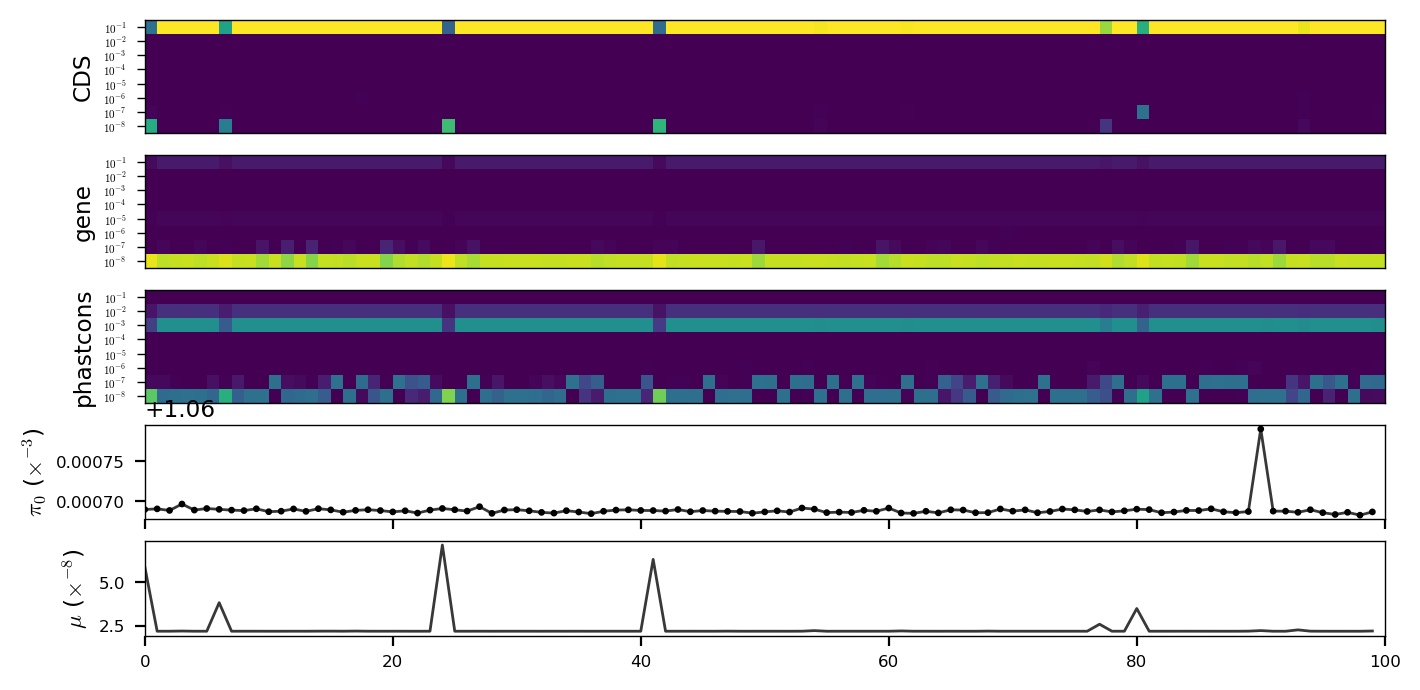

In [47]:
optim_diagnotics_plot(models['phastcons > CDS > genes'].fits[('chb', '1000000', 'sparse')]['mbp'])

Clearly, the best MLE is the more common one, and we could run more starts and end up with this. I had not seen this outlier in other test runs. So I remove this true highest MLE since the other makes more sense. The alternative would be to base the results on this, but from the plot above, it is clearly an aberation, so better to remove and mention.

In [48]:
optim = models['phastcons > CDS > genes'].fits[('chb', '1000000', 'sparse')]['mbp'].optim
models['phastcons > CDS > genes'].fits[('chb', '1000000', 'sparse')]['mbp']._load_optim(optim, index=1)

In [49]:
models['phastcons > CDS > genes'].fits[('yri', '1000000', 'sparse')]['mbp']

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


SimplexModel (interpolated w): 6 x 8 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250657908564.79294
number of successful starts: 10000 (100.0% total)
π0 = 0.00146801
π  = 0.00106447
μ_del  = 1.864e-08 
Ne = 36,700 (if μ=1e-8), Ne = 18,350 (if μ=2e-8)
R² = 68.1582% (in-sample)  68.4462% (out-sample)
W = 
          CDS    gene    phastcons
------  -----  ------  -----------
1e-08       1   0.907        0
1e-07       0   0.001        0
1e-06       0   0            0
1e-05       0   0.035        0
0.0001      0   0            0
0.001       0   0            0.477
0.01        0   0            0.199
0.1         0   0.057        0.323

In [50]:
df = summarize_models(models)

In [51]:
df_melted = df.melt(id_vars=['model', 'pop', 'fit_type', 'model_num', 'pop_num'], 
                    value_vars=['mbp_mu', 'mb_mu'], 
                    var_name='b_type', 
                    value_name='mu')

df_melted['b_type'] = [{'mbp_mu': "B'", 'mb_mu': "B"}[x] for x in df_melted['b_type']]

In [52]:
df_melted.head()

,model,pop,fit_type,model_num,pop_num,b_type,mu
0,CADD 6%,ceu,full,3,1,B',1.536526e-08
1,CADD 6%,ceu,sparse,3,1,B',2.121474e-08
2,CADD 6%,chb,full,3,2,B',1.508313e-08
3,CADD 6%,chb,sparse,3,2,B',2.124189e-08
4,CADD 6%,yri,full,3,0,B',1.461169e-08


In [53]:
df

,model,pop,window,fit_type,mb_R2,mbp_R2,mbp_loo_R2,mbp_mu,mb_mu,mbp_mu_sigma,mb_mu_sigma,pop_num,model_num
16,CADD 6%,ceu,1000000,full,0.574152,0.629394,0.617433,1.536526e-08,1.738999e-09,7.362064e-09,None,1,3
17,CADD 6%,ceu,1000000,sparse,0.628419,0.628555,0.616574,2.121474e-08,2.108397e-08,NaN,None,1,3
12,CADD 6%,chb,1000000,full,0.553135,0.613115,0.596228,1.508313e-08,1.727072e-09,1.751337e-08,None,2,3
13,CADD 6%,chb,1000000,sparse,0.611997,0.612064,0.595382,2.124189e-08,2.116961e-08,NaN,None,2,3
14,CADD 6%,yri,1000000,full,0.629597,0.680839,0.680751,1.461169e-08,1.720629e-09,5.998186e-09,None,0,3
15,CADD 6%,yri,1000000,sparse,0.680109,0.680280,0.680414,2.091161e-08,2.071645e-08,NaN,None,0,3
22,CADD 8%,ceu,1000000,full,0.579532,0.621245,0.608009,1.157189e-08,1.741545e-09,2.558113e-09,None,1,5
23,CADD 8%,ceu,1000000,sparse,0.620397,0.620610,0.605937,1.602976e-08,1.587578e-08,2.866875e-10,None,1,5
18,CADD 8%,chb,1000000,full,0.558558,0.606265,0.588768,1.112791e-08,1.732859e-09,6.905167e-09,None,2,5
19,CADD 8%,chb,1000000,sparse,0.605483,0.605692,0.586497,1.609759e-08,1.600089e-08,5.758173e-08,None,2,5


### Test Figure

/tmp/ipykernel_70400/1498923020.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([x.get_text().replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in xticks], fontsize=6)
/tmp/ipykernel_70400/1498923020.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels([x.get_text().replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in xticks], fontsize=6)


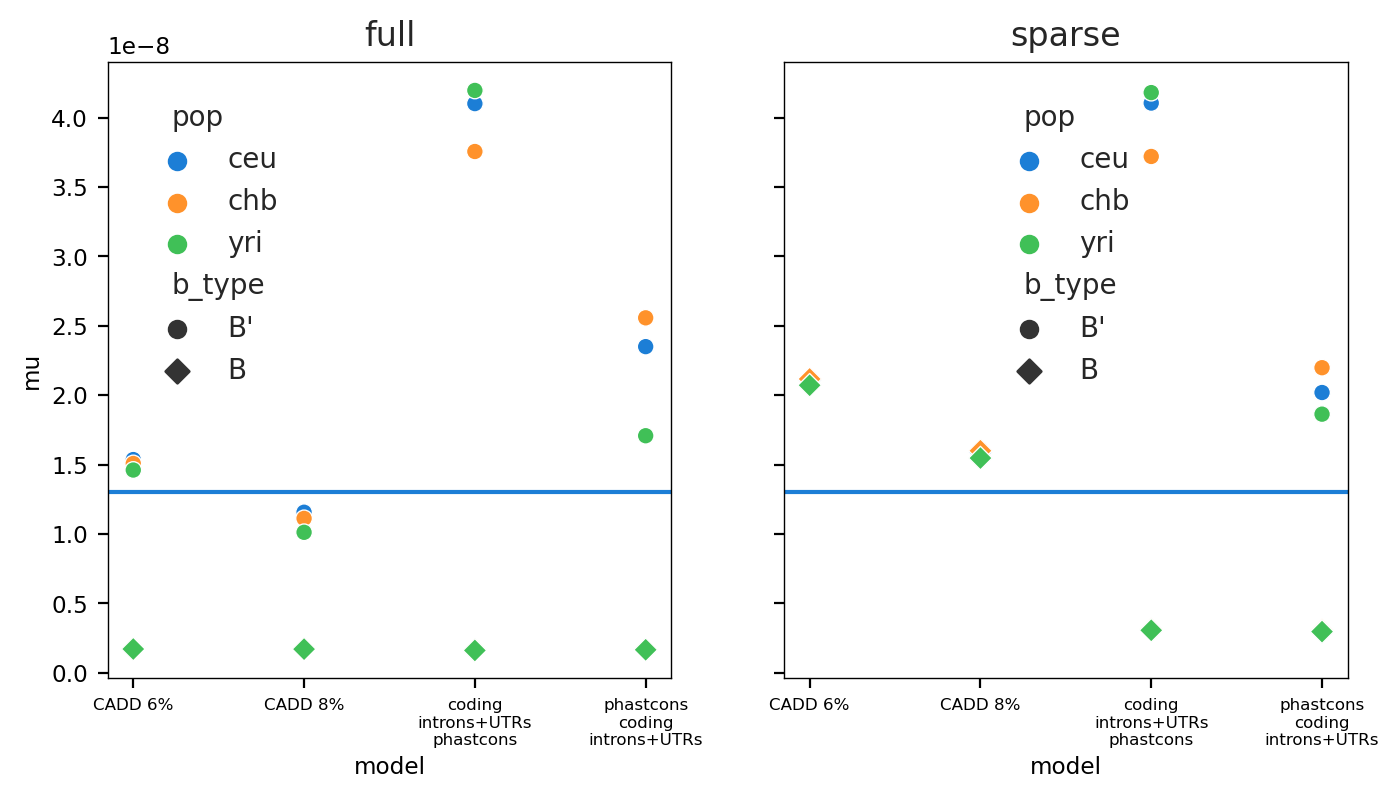

In [54]:
import matplotlib.ticker as ticker

df_melted = df.melt(id_vars=['model', 'pop', 'fit_type'], 
                    value_vars=['mbp_mu', 'mb_mu'], 
                    var_name='b_type', 
                    value_name='mu')

df_melted['b_type'] = [{'mbp_mu': "B'", 'mb_mu': "B"}[x] for x in df_melted['b_type']]

fig, ax = plt.subplots(ncols=2, sharey=True)
for i, fit_type in enumerate(df_melted['fit_type'].unique()):
    sns.scatterplot(x='model', y='mu', hue='pop', style='b_type', data=df_melted.loc[df_melted['fit_type'] == fit_type], ax=ax[i], markers=["o", "D"])
    #ax[i].semilogy()
    ax[i].axhline(1.3e-8)
    ax[i].set_title(fit_type)
    
    #ax[i].set_xticks(np.array(list(model_to_num.values())) + offset/2)
    xticks = ax[i].get_xticklabels()
    ax[i].set_xticklabels([x.get_text().replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in xticks], fontsize=6)
    ax[i].tick_params(axis='y', which='minor', labelsize=8)


### Figure Code

In [57]:
df

,model,pop,window,fit_type,mb_R2,mbp_R2,mbp_loo_R2,mbp_mu,mb_mu,mbp_mu_sigma,mb_mu_sigma,pop_num,model_num
16,CADD 6%,ceu,1000000,full,0.574152,0.629394,0.617433,1.536526e-08,1.738999e-09,7.362064e-09,None,1,3
17,CADD 6%,ceu,1000000,sparse,0.628419,0.628555,0.616574,2.121474e-08,2.108397e-08,NaN,None,1,3
12,CADD 6%,chb,1000000,full,0.553135,0.613115,0.596228,1.508313e-08,1.727072e-09,1.751337e-08,None,2,3
13,CADD 6%,chb,1000000,sparse,0.611997,0.612064,0.595382,2.124189e-08,2.116961e-08,NaN,None,2,3
14,CADD 6%,yri,1000000,full,0.629597,0.680839,0.680751,1.461169e-08,1.720629e-09,5.998186e-09,None,0,3
15,CADD 6%,yri,1000000,sparse,0.680109,0.680280,0.680414,2.091161e-08,2.071645e-08,NaN,None,0,3
22,CADD 8%,ceu,1000000,full,0.579532,0.621245,0.608009,1.157189e-08,1.741545e-09,2.558113e-09,None,1,5
23,CADD 8%,ceu,1000000,sparse,0.620397,0.620610,0.605937,1.602976e-08,1.587578e-08,2.866875e-10,None,1,5
18,CADD 8%,chb,1000000,full,0.558558,0.606265,0.588768,1.112791e-08,1.732859e-09,6.905167e-09,None,2,5
19,CADD 8%,chb,1000000,sparse,0.605483,0.605692,0.586497,1.609759e-08,1.600089e-08,5.758173e-08,None,2,5


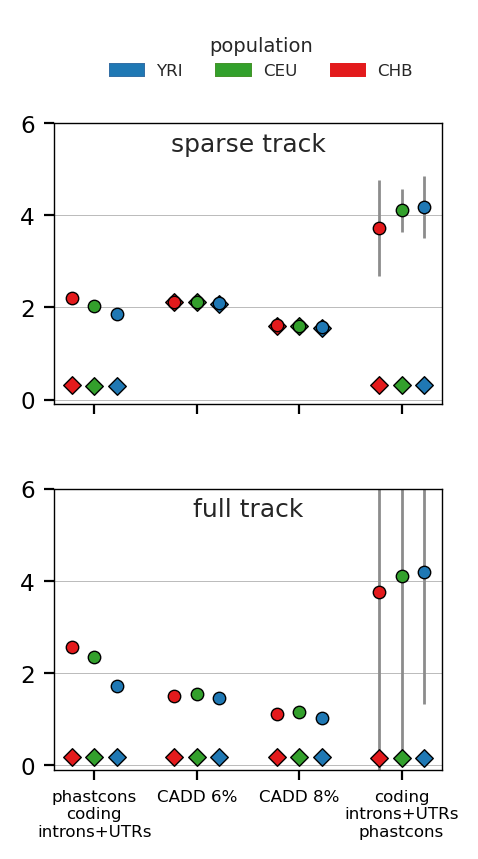

In [55]:
fig, axs = plt.subplots(nrows=2, figsize=(2.5, 4.2), sharex=True, gridspec_kw=dict(hspace=0.3))

ms = 20
offset = 0.44
center = len(all_pops) / 2

x_min = 1000
i = 0
res = []

for j, fit_type in enumerate(['sparse', 'full']):
    ax = axs[j]
    i = 0
    for pop in pop_to_num.keys():
        ci = i*2
        dfx = df.loc[(df['fit_type'] == fit_type) & (df['pop'] == pop)]
        dfxx = dfx.loc[np.isfinite(dfx['mbp_mu_sigma']) & (dfx['model'] == 'CDS > genes > phastcons')]
        ax.errorbar(dfxx['model_num'] - offset*(dfxx['pop_num'] - center), dfxx['mbp_mu'], 2*dfxx['mbp_mu_sigma'], 
                    #color=pop_cols[ci+1, :], 
                    color='0.55',
                    elinewidth=1,
                    zorder=2)
        
        ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mbp_mu'], color=pop_cols[ci+1, :], s=ms, linewidths=0.5, edgecolors='k', zorder=10)
        #scatter = ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mu'], color=pop_cols[ci+1, :], label=pop.upper(), s=ms, linewidths=0.5, edgecolors='k')
        dfx = df.loc[(df['fit_type'] == fit_type) & (df['pop'] == pop)]
        ax.scatter(dfx['model_num'] - offset*(dfx['pop_num'] - center), dfx['mb_mu'], color=pop_cols[ci+1, :], s=ms,
                   zorder=6,
                   marker='D', linewidths=0.5, edgecolors='k')        
        
        ax.set_axisbelow(True)
        i += 1
    ax.text(0.5, 0.9, fit_type + " track", fontsize=9,  transform=ax.transAxes, ha='center')
    formatter = ticker.FuncFormatter(lambda x, p: int(np.round(x*1e8)))
    ax.yaxis.set_major_formatter(formatter)

    ax.set_xticks(np.array(list(model_to_num.values())) + offset/2)
    ax.set_xticklabels([x.replace(' > ', '\n').replace('genes', 'introns+UTRs').replace('CDS', 'coding') for x in model_to_num.keys()], fontsize=6)
    ax.set_ylim(-0.1e-8, 6e-8)
    ax.grid(axis='y', zorder=-1, linewidth=0.3,
            #linestyle='dashed'
           )

    
patches = []
populations = list(pop_to_num.keys())
for i in range(0, len(pop_cols), 2):
    patch2 = mpatches.Patch(color=pop_cols[i+1, :])
    patches.append((patch1, patch2))
    
legend = axs[0].legend(loc=(0.1, 1.1), ncols=3, fontsize=6, title='population', title_fontsize=7, 
                      handles=patches, labels=[x.upper() for x in populations])

plt.savefig('../manuscript/figures/subfigure_pop_mu.pdf', bbox_inches='tight')

(<Figure size 1600x800 with 1 Axes>, <Axes: xlabel='t', ylabel='probability'>)

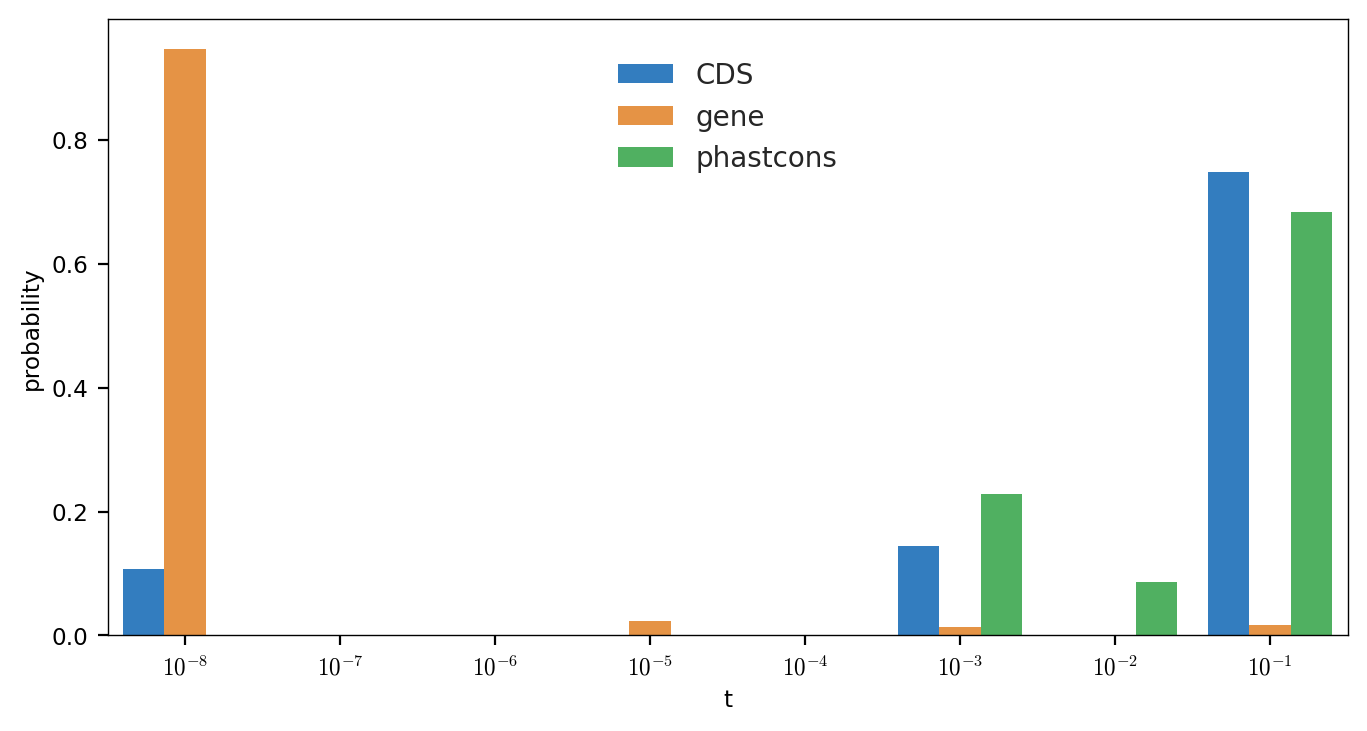

In [56]:
models['CDS > genes > phastcons'].fits[('ceu', '1000000', 'sparse')]['mbp'].dfe_plot()

## DFE Figure

Let's see if the DFEs we get out make sense. There is a tradeoff in terms of interpretability (e.g. not CADD or phastcons) and goodness of fit.

In [46]:
models.keys()

dict_keys(['phastcons > CDS > genes', 'CDS > genes > phastcons', 'CADD 6%', 'CADD 8%'])

Let's look at the two CADD models:

#### Yoruba DFEs between Models

### CADD DFEs

In [50]:
from bgspy.utils import latex_scientific_notation

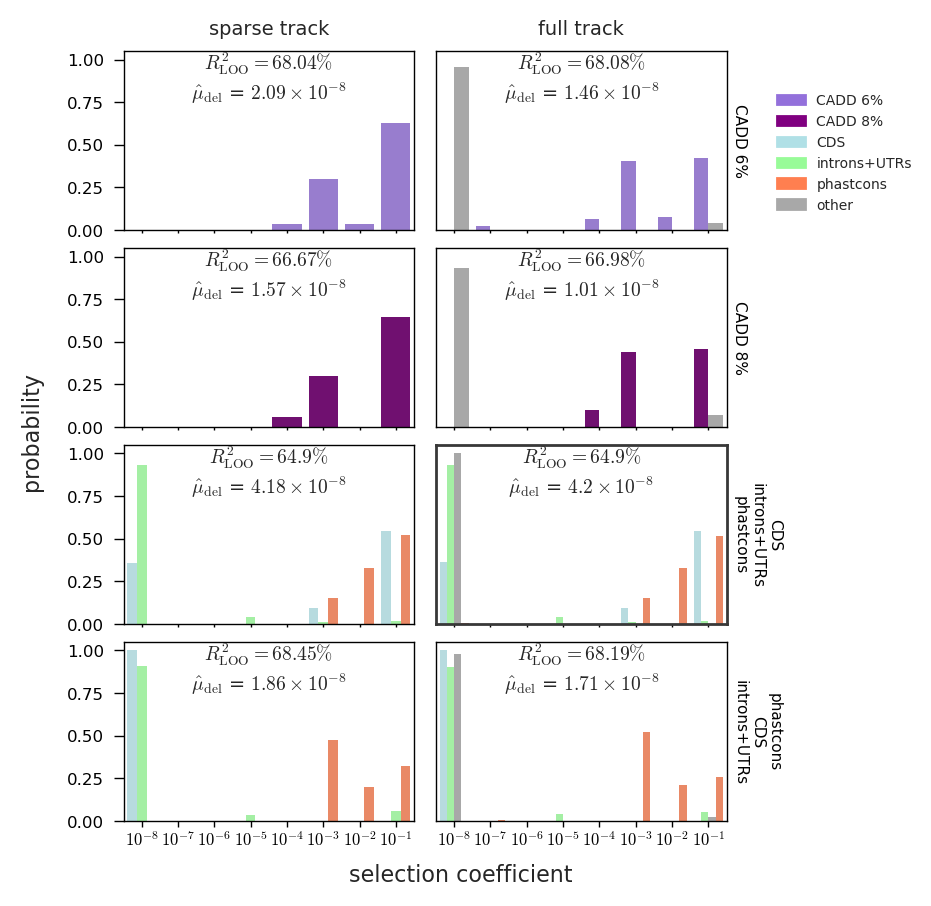

In [603]:
def model_dfe_plot(models, pop):
    dfe_colors = {"cadd6": "mediumpurple", "cadd8": "purple", 
                  "CDS": "powderblue", "gene": "palegreen",
                  "phastcons": "coral", "other": "0.66"}
    rows = ['CADD 6%', 'CADD 8%', 'CDS > genes > phastcons', 'phastcons > CDS > genes']
    fig, axs = plt.subplots(ncols=2+1, nrows=len(rows), sharex=True, sharey=True, figsize=(4.5, 5), 
                            gridspec_kw=dict(hspace=0.1, wspace=0.1), width_ratios=[2, 2, 0.5])
    ax = axs[:, :2]

    for i, fit_type in enumerate(['sparse', 'full']):
        for j, model_name in enumerate(rows):
            fit = models[model_name].fits[(pop, '1000000', fit_type)]['mbp']
            fit.dfe_plot(figax=(fig, ax[j, i]), add_legend=False, barplot_kwargs=dict(palette=dfe_colors))

            ax[j, i].legend_.remove()
            if j >= 1:
                ax[j, i].set_xlabel(None)
            else:
                ax[j, i].set_xlabel(None)
                ax[j, i].set_title(fit_type +" track", fontsize=7)

            if i == 0:
                ax[j, i].set_ylabel(None)
            else:
                ax[j, i].set_ylabel(None)
            if i == 1:
                ax[j, i].yaxis.set_label_position("right")
                if model_name.startswith('CADD'):
                    model_name = "\n\n"+model_name 
                model_name = model_name.replace('genes', 'introns+UTRs')
                ax[j, i].set_ylabel(model_name.replace(' > ', '\n'), rotation=-90, labelpad=20, fontsize=5.5)

            ax[j, i].tick_params(axis="x", labelsize=6, pad=1)
            ax[j, i].tick_params(axis="y", labelsize=6)

            mu = fit.mle_mu
            ax[j, i].text(0.5, 0.73, f"$R_\mathrm{{LOO}}^2 = {np.round(100*fit.loo_R2(), 2)}\%$\n$\hat{{\mu}}_\\mathrm{{del}}$ = {latex_scientific_notation(mu)}",  
                          transform=ax[j, i].transAxes, ha='center', fontsize=7)

            # these are to match buffalo.mpstyle
            for side in ['left', 'right', 'top', 'bottom']:
                ax[j, i].spines[side].set_linewidth(0.5)


            ax[j, i].xaxis.set_tick_params(width=0.5, length=2)
            ax[j, i].yaxis.set_tick_params(width=0.5, color='k')
            if j != 3:
                ax[j, i].xaxis.set_tick_params(length=1.1, color='k')
            if i != 0:
                ax[j, i].yaxis.set_tick_params(length=0, color='k')



    for fax in axs[:, 2]:
        fax.axis('off')

    fig.text(0.01, 0.5, 'probability', va='center', rotation='vertical', fontsize=8)
    fig.text(0.5, 0.05, 'selection coefficient', ha='center', fontsize=8) 

    new_labels = {'cadd6': 'CADD 6%', 'cadd8': 'CADD 8%', 'gene': 'introns+UTRs'}

    #lega = ['cadd6', 'cadd8', 'other']
    legend_handles = [mpatches.Patch(color=color, label=new_labels.get(label, label)) for label, color in dfe_colors.items()]
    fig.legend(loc=(0.82, 0.75), handles=legend_handles, fontsize=5)
    return fig, ax



#legb = ['CDS', 'phastcons', 'gene', 'other']
#legend_handles = [mpatches.Patch(color=color, label=new_labels.get(label, label)) for label, color in dfe_colors.items() if label in legb]
#fig.legend(loc=(0.81, 0.5), handles=legend_handles, fontsize=5)

fig, ax = model_dfe_plot(models, 'yri')
for side in ['left', 'right', 'top', 'bottom']:
    ax[2, 1].spines[side].set_linewidth(1)
    ax[2, 1].spines[side].set_color('0.22')
fig.savefig('../manuscript/figures/figure_yri_dfe.pdf', bbox_inches='tight')

#### For CEU

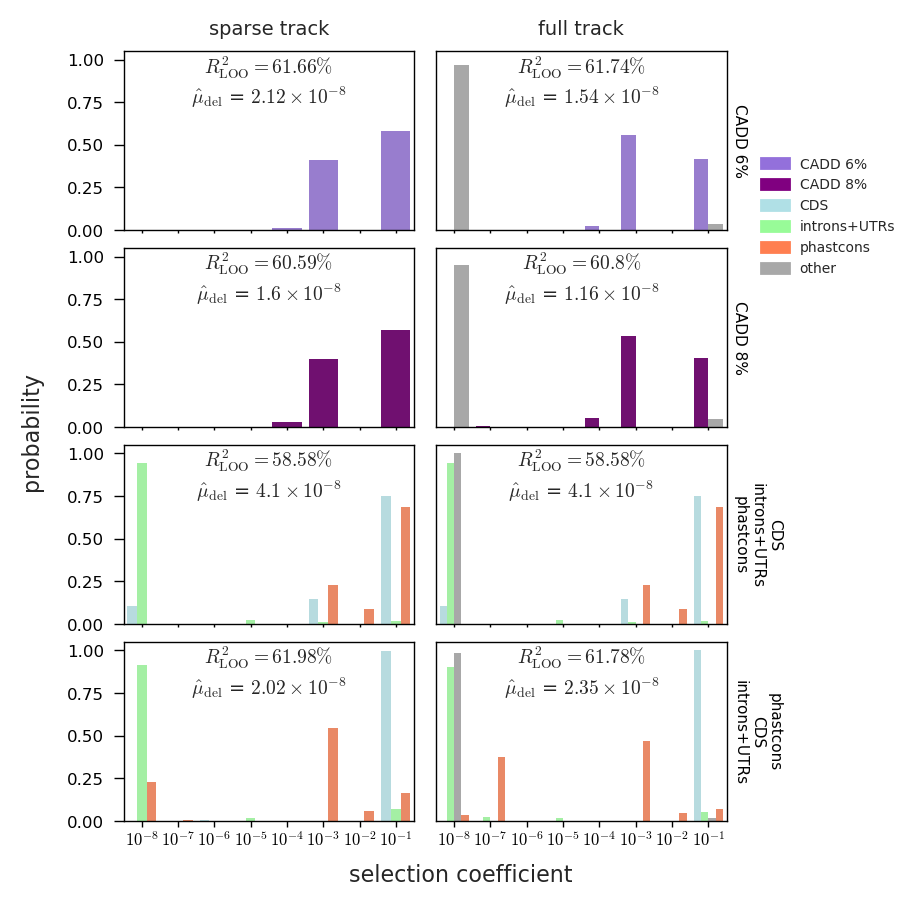

In [597]:
fig, ax = model_dfe_plot(models, 'ceu')
fig.savefig('../manuscript/figures/figure_ceu_dfe.pdf', bbox_inches='tight')

#### For CHB

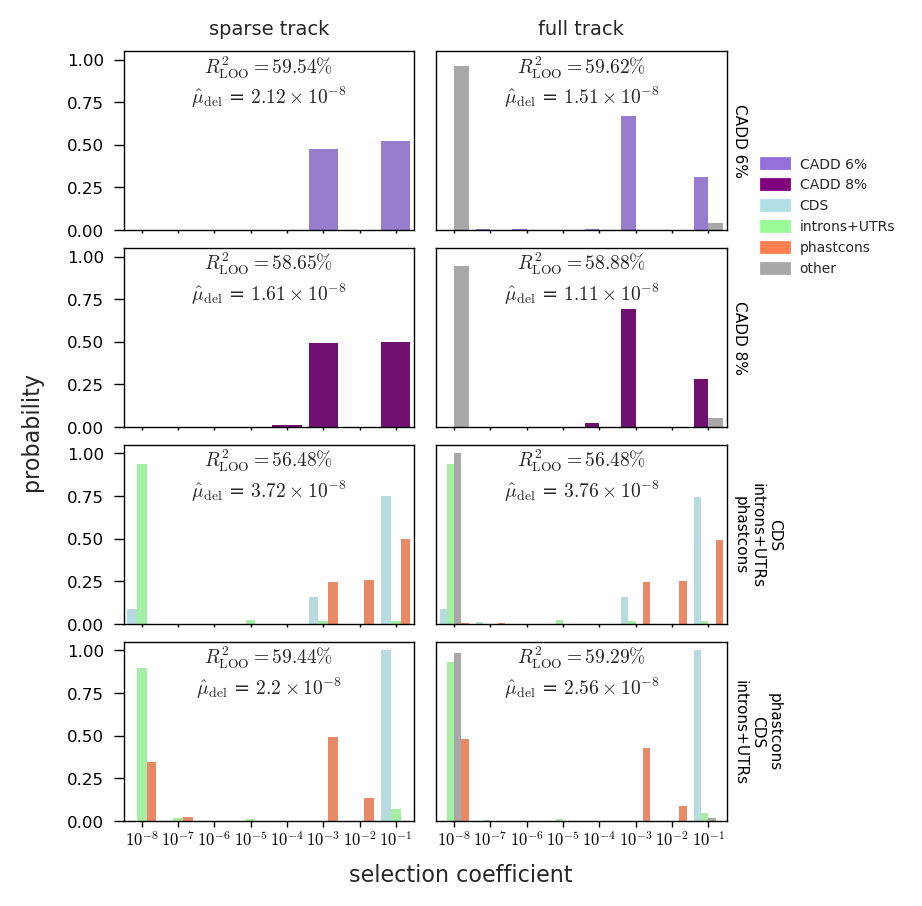

In [598]:
fig, ax = model_dfe_plot(models, 'chb')
fig.savefig('../manuscript/figures/figure_chb_dfe.pdf', bbox_inches='tight')

### Population DFEs

In [121]:
dfes = defaultdict(lambda: defaultdict(dict))
dfe_errors = defaultdict(lambda: defaultdict(dict))

mus = defaultdict(lambda: defaultdict(dict))
mus_sigma = defaultdict(lambda: defaultdict(dict))

fits = dict()
for model_name, model in models.items():
    # the order is to make colors match R2 plot
    for pop in ['yri', 'ceu', 'chb']:
        fit = model.fits[(pop, '1000000', 'full')]['mbp']
        fits[(model_name, pop)] = fit
        res = fit.W_stderrs()
        if res is None:
            continue
        mus[(model_name, pop)] = fit.mle_mu
        ci = None
        if fit.sigma_ is not None:
            ci = 2*fit.sigma_[1]
        mus_sigma[(model_name, pop)] = ci
        means, errors = res
        for feature in means:
            dfes[model_name][feature][pop] = means[feature]
            if errors is not None:
                dfe_errors[model_name][feature][pop] = errors[feature]
                
dfes = dict(dfes)
dfe_errors = dict(dfe_errors)
mus = dict(mus)
mus_sigma = dict(mus_sigma)

In [122]:
from bgspy.plots import get_figax

def dfe_plot_alt(x_labels, groups, errors=None, keys=None, figax=None):
    fig, ax = get_figax(figax)
    nf = len(groups)
    x = np.arange(len(x_labels))
    
    width = 0.2  # the width of the bars
    mid_offset = -1
    multiplier = mid_offset

    bar_pos = []
    keys = groups.keys() if keys is None else keys
    i = 0
    for feature in keys:
        means = groups[feature]
        offset = width * multiplier
        pos = x + offset
        bar_pos.append(pos)
        rects = ax.bar(pos, means, width, label=feature.upper(), color=pop_cols[1::2][i, :])
        i += 1
        if errors:
            ax.errorbar(pos, means, errors[feature], 
                        fmt='none', capsize=0, elinewidth=0.8, alpha=0.8, 
                        color='0.44')
        multiplier += 1
    
    ends = list(zip(bar_pos[0], bar_pos[-1]))    
    for i in range(len(x)):
        s, e = ends[i]
        #ax.plot((s-width/2, e+ width/2), (0, 0), c='k')

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xticks(x + width, x_labels)
    ax.set_ylim(-0.001, None)
    

#### CDS > genes > phastcons

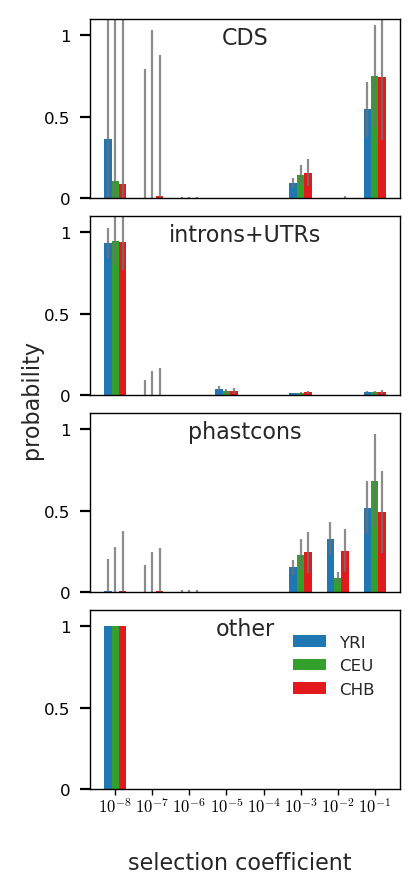

In [127]:
model_name = 'CDS > genes > phastcons'

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(2, 5), sharex=True,)

feature_labels = { 'CDS': 'CDS', 'gene':'introns+UTRs', 'phastcons': 'phastcons', 'other':'other'}
features = dfes['CDS > genes > phastcons']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes[model_name][feature], 
                 errors=dfe_errors[model_name][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.86, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8,)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    ax[i].xaxis.set_tick_params(width=0.5, length=2)
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)
ax[3].tick_params(axis='x', pad=0.5)
fig.text(-0.05, 0.5, 'probability', va='center', rotation='vertical', fontsize=8)
fig.text(0.5, 0.03, 'selection coefficient', ha='center', fontsize=8)


fig.savefig('../manuscript/figures/subfigure_pop_dfe.pdf', bbox_inches='tight')

Text(0.5, 0.03, 'selection coefficient')

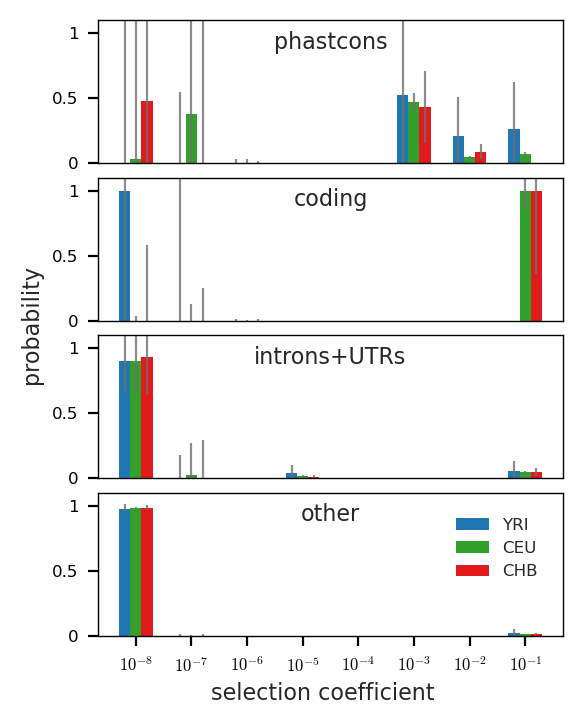

In [124]:
model_name = 'phastcons > CDS > genes'

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'CDS': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['CDS > genes > phastcons']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes[model_name][feature], 
                 errors=dfe_errors[model_name][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)
fig.text(-0.005, 0.5, 'probability', va='center', rotation='vertical', fontsize=8)
fig.text(0.5, 0.03, 'selection coefficient', ha='center', fontsize=8)

In [1241]:
dfes.keys()

dict_keys(['phastcons > CDS > genes', 'CDS > genes > phastcons', 'CADD 6%', 'CADD 8%'])

In [1249]:
dfes['CADD 6%'].keys()

dict_keys(['cadd6', 'other', 'CADD 6%'])

In [1257]:
feature

'CADD 6%'

In [1282]:
dfe_errors.keys()

dict_keys(['phastcons > CDS > genes', 'CDS > genes > phastcons'])

KeyError: 'cadd6'

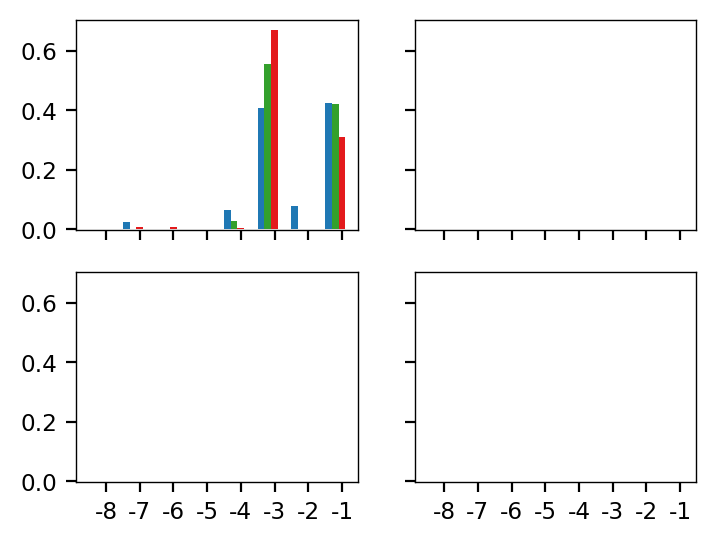

In [128]:
cadd_models = ['CADD 6%', 'CADD 8%']

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(4, 3), sharex=True, sharey=True)

for j, model_name in enumerate(cadd_models):
    features = dfes[model_name]
    for i, feature_key in enumerate(features):
        dfe_plot_alt(np.arange(-8, 0), 
                     dfes[model_name][feature_key], 
                     #errors=dfe_errors[model_name][feature_key],
                     figax=(fig, ax[i, j]))
        ax[i, j].text(0.5, 0.8, feature_labels[feature_key], transform=ax[i, j].transAxes, ha='center', fontsize=8)
        ax[i, j].set_ylim(0, 1.1)
        ax[i, j].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
        if i < 3:
            ax[i, j].xaxis.set_ticks_position('none') 

    ax[1, j].legend(ncols=1, prop={'size': 6})
    fig.subplots_adjust(wspace=0, hspace=0.1)
    ts = np.arange(-8, 0)
    ax[1, j].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)
    fig.text(-0.005, 0.5, 'probability', va='center', rotation='vertical', fontsize=8)
    fig.text(0.5, 0.03, 'selection coefficient', ha='center', fontsize=8)

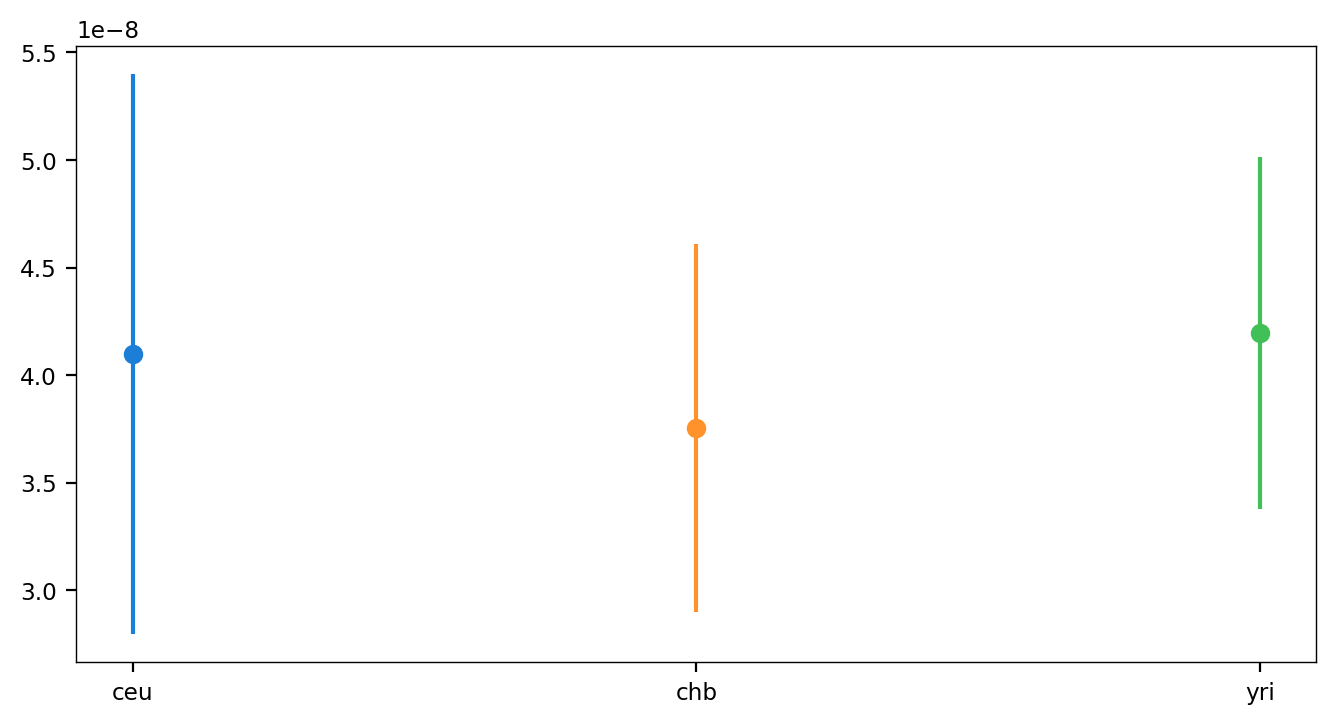

In [716]:
fig, ax = plt.subplots()

for pop in all_pops:
    ax.scatter(pop, mus['CDS > genes > phastcons', pop])
    ax.errorbar(pop, mus['CDS > genes > phastcons', pop], mus_sigma['CDS > genes > phastcons', pop])

For completeness, we also show the phastcons-priority version. But this it is worth noting that we expect the phastcons-priority eliminates a huge fraction of coding basepairs. See:

**CDS-priority**

    $ python ../../tools/bedstats.py ../CDS_genes_phastcons__decode/tracks/CDS_genes_phastcons__decode_full.bed.gz ../../data/fit_annotation/hg38_seqlens.tsv
      other   43.1106%
      gene    54.2338%
      phastcons       1.4461%
      CDS     1.2094%

**phastcons-priority**

    $ python ../../tools/bedstats.py ../phastcons_CDS_genes__decode/tracks/phastcons_CDS_genes__decode_full.bed.gz ../../data/fit_annotation/hg38_seqlens.tsv
      other   43.1106%
      gene    51.4035%
      phastcons       5.0823%
      CDS     0.4036%

Hence, there just isn't enough information to estimate CDS from the Phastcons priority model. Which we see in the DFE:

Text(0.5, 0.03, 'selection coefficient')

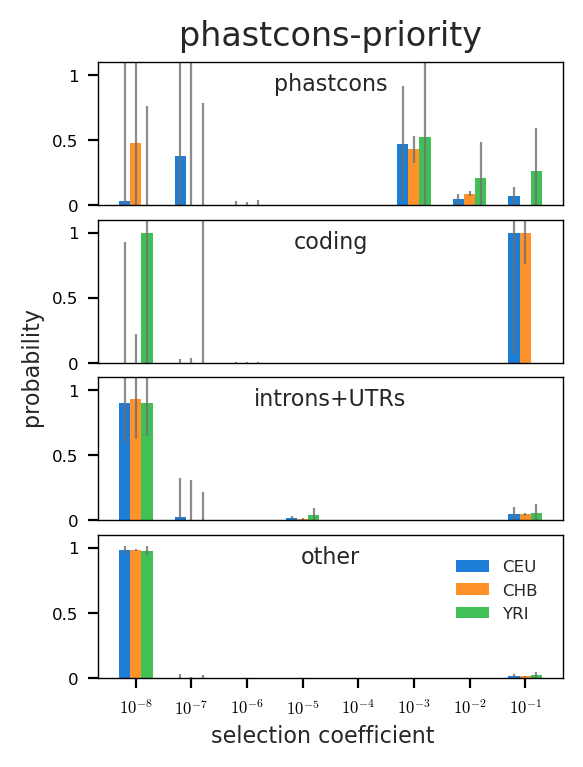

In [1048]:
model_name = 'phastcons > CDS > genes'

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'CDS': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['CDS > genes > phastcons']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes[model_name][feature], 
                 errors=dfe_errors[model_name][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[0].set_title('phastcons-priority')
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)
fig.text(-0.005, 0.5, 'probability', va='center', rotation='vertical', fontsize=8)
fig.text(0.5, 0.03, 'selection coefficient', ha='center', fontsize=8)

In [1047]:
840 / 140

6.0

## Subsitution Rates

In [116]:
models['CDS > genes > phastcons'].predicts[('yri', '1000000', 'full')].groupby('feature').mean()

/tmp/ipykernel_28658/3253518381.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  models['CDS > genes > phastcons'].predicts[('yri', '1000000', 'full')].groupby('feature').mean()


,start,end,R,r,V,Vm,seglen
feature,,,,,,,
CDS,7.570805e+07,7.570821e+07,2.416390e-06,1.528513e-08,7.229208e-07,7.217196e-08,158.087704
gene,7.725869e+07,7.726030e+07,6.470993e-05,4.036825e-08,2.571075e-07,2.555854e-08,1602.961510
other,8.130288e+07,8.130331e+07,1.815551e-05,4.194293e-08,7.514288e-16,3.328657e-17,432.862310
phastcons,8.231222e+07,8.231224e+07,2.792062e-09,1.589586e-10,8.128073e-08,7.670735e-09,17.564708


## Rescaled Fits

In [ ]:
    
    
    
model_name = 'CDS > genes > phastcons'

fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'CDS': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['CDS > genes > phastcons']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes[model_name][feature], 
                 errors=dfe_errors[model_name][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)
fig.text(-0.02, 0.5, 'probability', va='center', rotation='vertical')

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

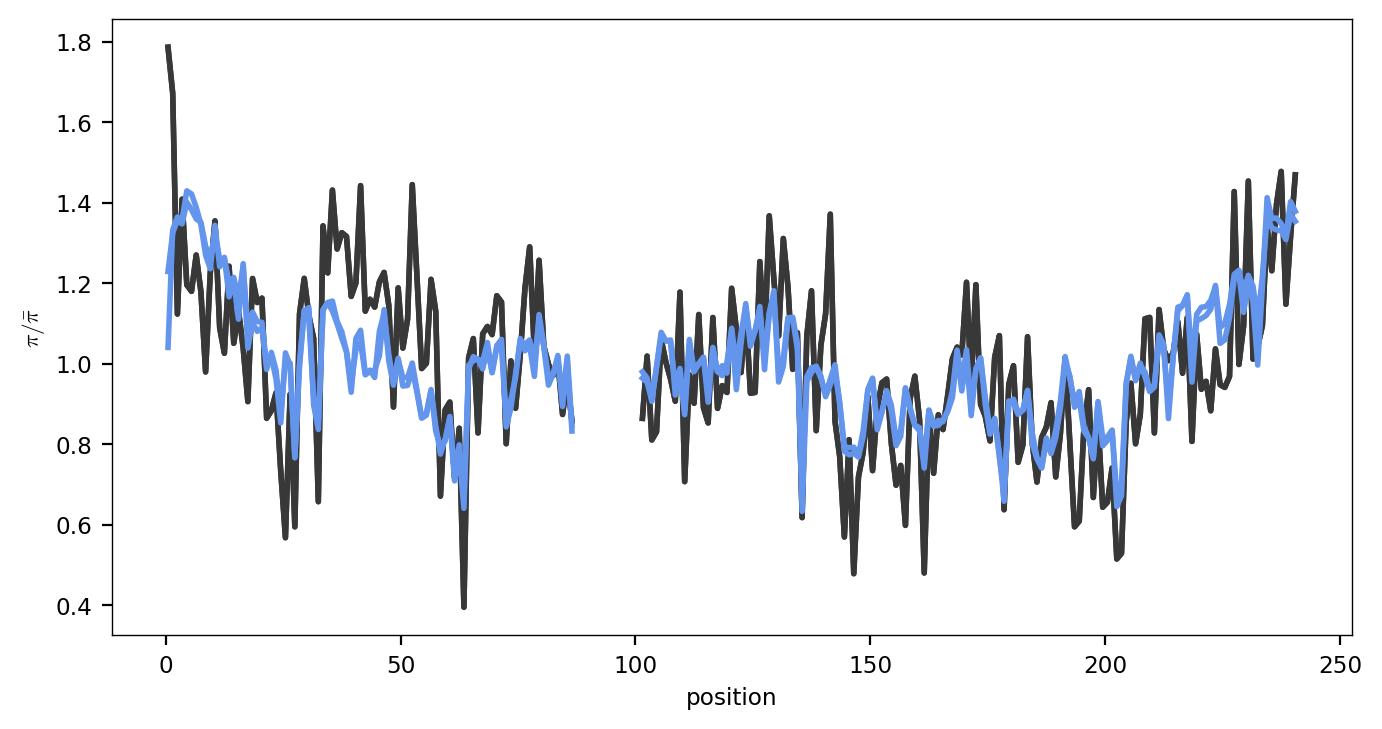

In [676]:
from bgspy.utils import load_pickle
a = load_pickle('../rescale_test.pkl')['mbp']

fig, ax = plt.subplots()

chrom = 'chr2'
a.predict_plot(chrom, figax=(fig, ax))
models['CDS > genes > phastcons'].fits[('yri', '1000000', 'full')]['mbp'].predict_plot(chrom, figax=(fig, ax))

In [608]:
[models['CDS > genes > phastcons'].fits[(p, '1000000', 'full')]['mbp'].mle_mu for p in ('yri', 'ceu', 'chb')]

[4.1951319881985956e-08, 4.100146002758266e-08, 3.755186157865858e-08]

In [604]:
a

/home/vsb/miniconda3/envs/bprime/lib/python3.10/site-packages/tabulate/__init__.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  (len(row) >= 1 and row[0] == SEPARATING_LINE)


SimplexModel (interpolated w): 6 x 8 x 3
  w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
  t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
  window size: 1.0 Mbp

ML estimates: (whole genome)
standard error method: None
negative log-likelihood: 250668360031.2082
number of successful starts: 10000 (100.0% total)
π0 = 0.00161782
π  = 0.00106447
μ_del  = 8e-07 
Ne = 40,445 (if μ=1e-8), Ne = 20,222 (if μ=2e-8)
R² = 66.2562% (in-sample)
W = 
          CDS    gene    phastcons
------  -----  ------  -----------
1e-08   0.959   0.998        0
1e-07   0       0            0.002
1e-06   0       0            0.786
1e-05   0       0            0.158
0.0001  0.002   0            0
0.001   0.004   0.001        0.001
0.01    0       0            0.027
0.1     0.035   0.001        0.026

In [548]:
main_B = load_pickle('../bmap_6x8grid_100000step_10000N__cadd6__decode_sparse.pkl')

In [549]:
rs_B = load_pickle('../rescaled_bmap_cadd6__decode_bmap_B_6x8grid_100000step_10000N__cadd6__decode_sparse.pkl')

In [557]:
rs_B.w, rs_B.t

(array([1.00000000e-11, 6.30957344e-11, 3.98107171e-10, 2.51188643e-09,
        1.58489319e-08, 1.00000000e-07]),
 array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01]))

In [560]:
rs_B.Bps['chr1'].shape

(2491, 6, 8, 1)

Text(0.5, 1.0, 'w = 2.511886431509582e-09, t=1e-05a')

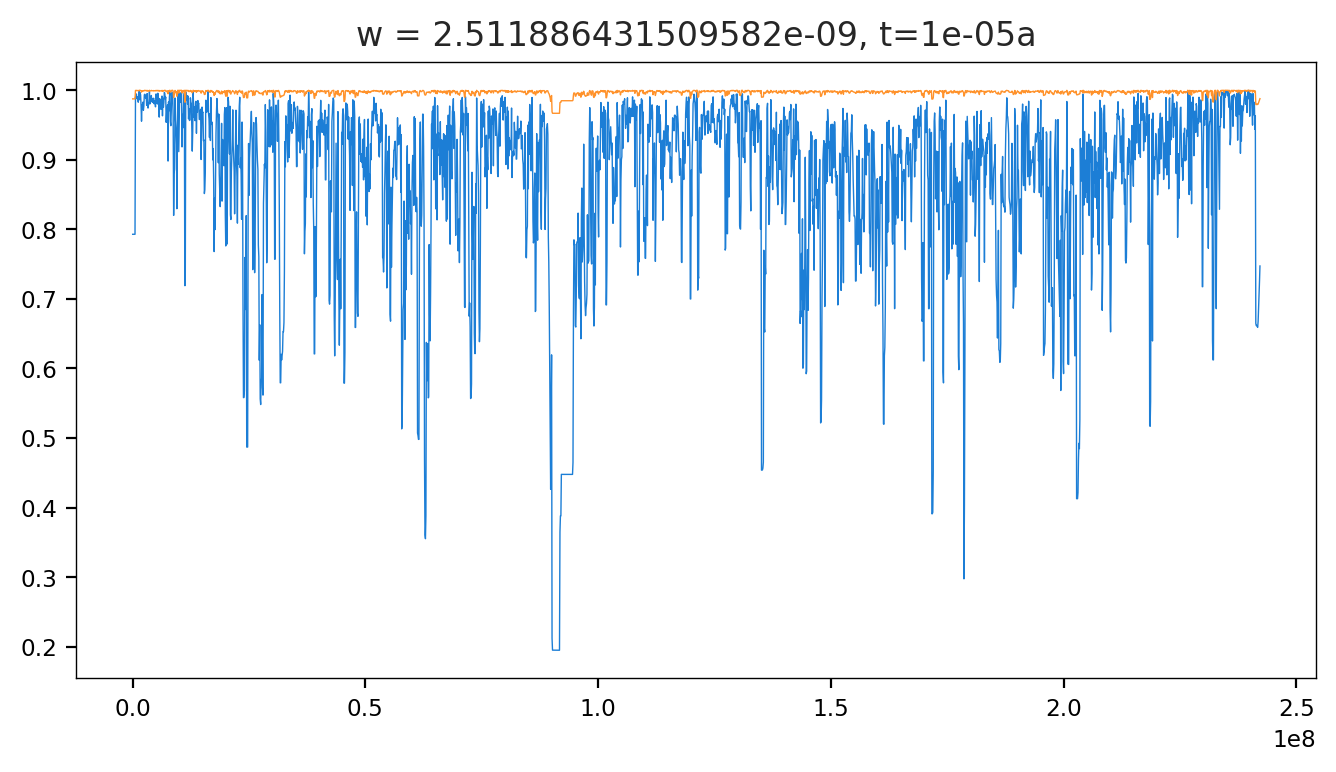

In [625]:
wi, ti = 3, 4
plt.plot(*main_B.BpScores[(chrom, rs_B.w[wi], rs_B.t[ti])], linewidth=0.5)
wi, ti = 3, 3
plt.plot(*rs_B.BpScores[(chrom, rs_B.w[wi], rs_B.t[ti])], linewidth=0.5)
plt.title(f"w = {rs_B.w[wi]}, t={rs_B.t[ti]}a")

In [531]:
dfes[model_name]

defaultdict(dict, {'phastcons': {}})

### Phastcons + CDS + genes


In [457]:
pcg = dict()
pcg_full = dict()
for pop in pops:
    pcg[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    pcg_full[pop] = load_pickle(f'../new_fits/phastcons_CDS_genes__decode//fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')

In [412]:
for pop in pops:
    nll_sparse, nll_full = pcg[pop]['mbp'].nll_, pcg_full[pop]['mbp'].nll_
    print((pop, nll_sparse, nll_full, nll_full < nll_sparse))

('yri', 250657908564.79294, 250656989872.19766, True)
('ceu', 197826612684.87143, 197825873893.4953, True)
('chb', 61822016128.79776, 61821783504.67356, True)


(<Figure size 1600x800 with 6 Axes>,
 array([<Axes: ylabel='CDS'>, <Axes: ylabel='gene'>,
        <Axes: ylabel='other'>, <Axes: ylabel='phastcons'>,
        <Axes: ylabel='$\\pi_0$ ($\\times^{-3}$)'>,
        <Axes: ylabel='$\\mu$ ($\\times^{-8}$)'>], dtype=object))

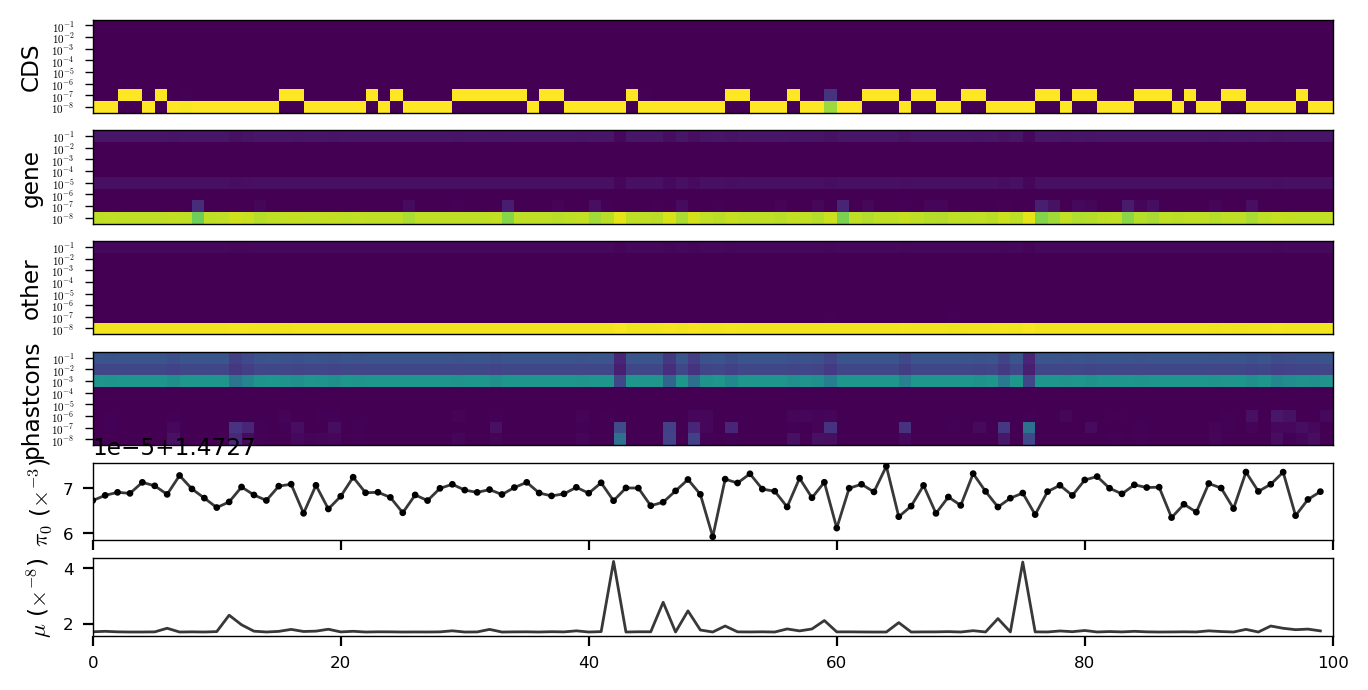

In [460]:
optim_diagnotics_plot(pcg_full['yri']['mbp'])

### Coefficient of Variation in Fits

The coefficient of variation of the predicted landscape is a function of spatial recombination and segments. Larger predictived CVs are determined by this.

In [399]:
cvs = dict()
for pop in pops:
    cvs[pop] = pcg[pop]['mbp'].coefvar()

Text(0.55, 0.15, 'Correlation: 0.75')

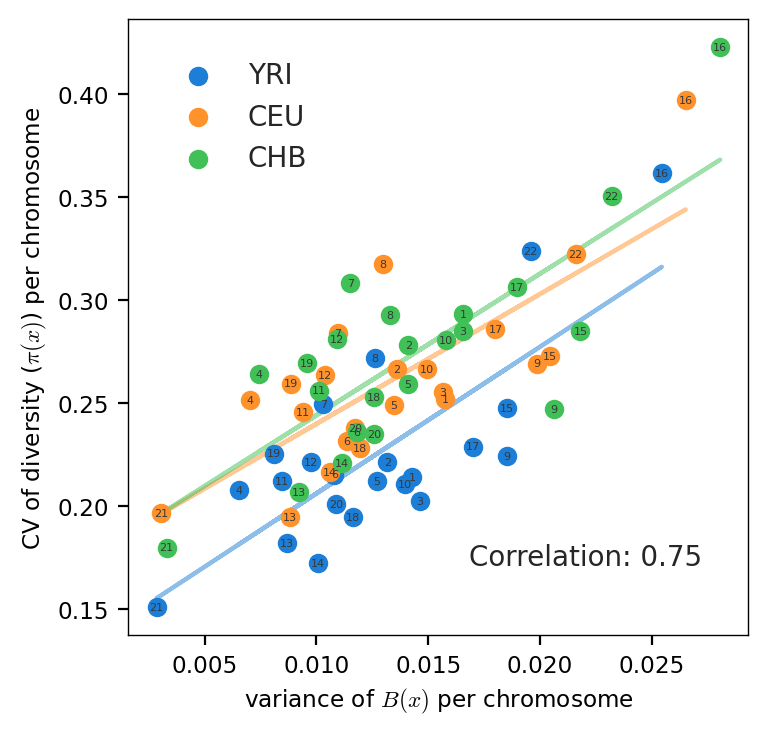

In [400]:
import matplotlib.patheffects as PathEffects
fig, ax = plt.subplots(figsize=(4, 4))
x, y = [], []


for pop in pops:
    d, p = list(cvs[pop][0].values()), list(cvs[pop][1].values())
    x.extend(d)
    y.extend(p)
    scatter = ax.scatter(p, d, label=pop.upper())
    for i, chrom in enumerate(cvs[pop][0].keys()):
        pass
        txt = ax.annotate(chrom.replace('chr', ''), xy=(p[i], d[i]), fontsize=4, color='0.22', va='center', ha='center')
        #txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='0.22')])
    m, b, *a = stats.linregress(p, d)
    ax.plot(p, [m * xi + b for xi in p], color=scatter.get_facecolor()[0], alpha=0.5, zorder=-10)

ax.set_xlabel('variance of $B(x)$ per chromosome')
ax.set_ylabel('CV of diversity ($\pi(x)$) per chromosome')
#ax.axline((0.05, 0.05), slope=1, c='0.22')
ax.legend(ncol=1)

cc = np.corrcoef(x, y)[0, 1]
ax.text(
    
    0.55,
    0.15,
    f"Correlation: {cc:.2f}",
    transform=ax.transAxes,
    verticalalignment="top",
)

In [105]:
stats.linregress(p, d).rvalue**2

0.5606841030998159

This is a version for talks, etc to show that populations do not have specific fits.

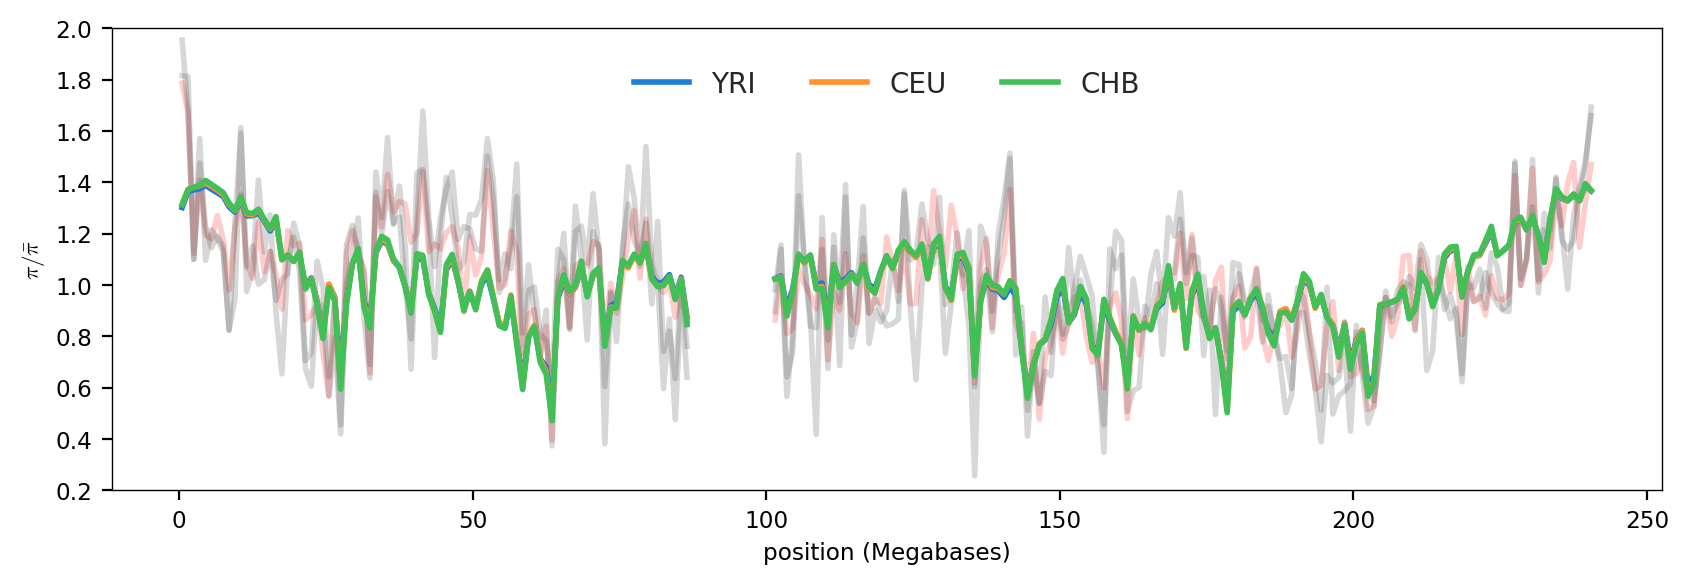

In [542]:
chrom = 'chr2'
cols = sns.color_palette()
    
figax = plt.subplots(figsize=(10, 3))
fig, ax = figax
pis = []
ax.set_ylim(0.2, 2)
for i, pop in enumerate(pops):
    fit = pcg[pop]['mbp']
    midpoints, pi = fit.bins.pi_pairs(chrom)
    pis.append(pi)
    if pop == 'yri':
        fit.predict_plot(chrom, figax=figax, pi_col='r', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())
    else:
        fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())
    

    ax.legend()
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    ax.set_xlabel("position (Megabases)")
    
    plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_{i}.pdf")

/tmp/ipykernel_57287/4286726797.py:19: RuntimeWarning: Mean of empty slice
  ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')


(<Figure size 2000x600 with 1 Axes>,
 <Axes: xlabel='position', ylabel='$\\pi/\\bar{\\pi}$'>)

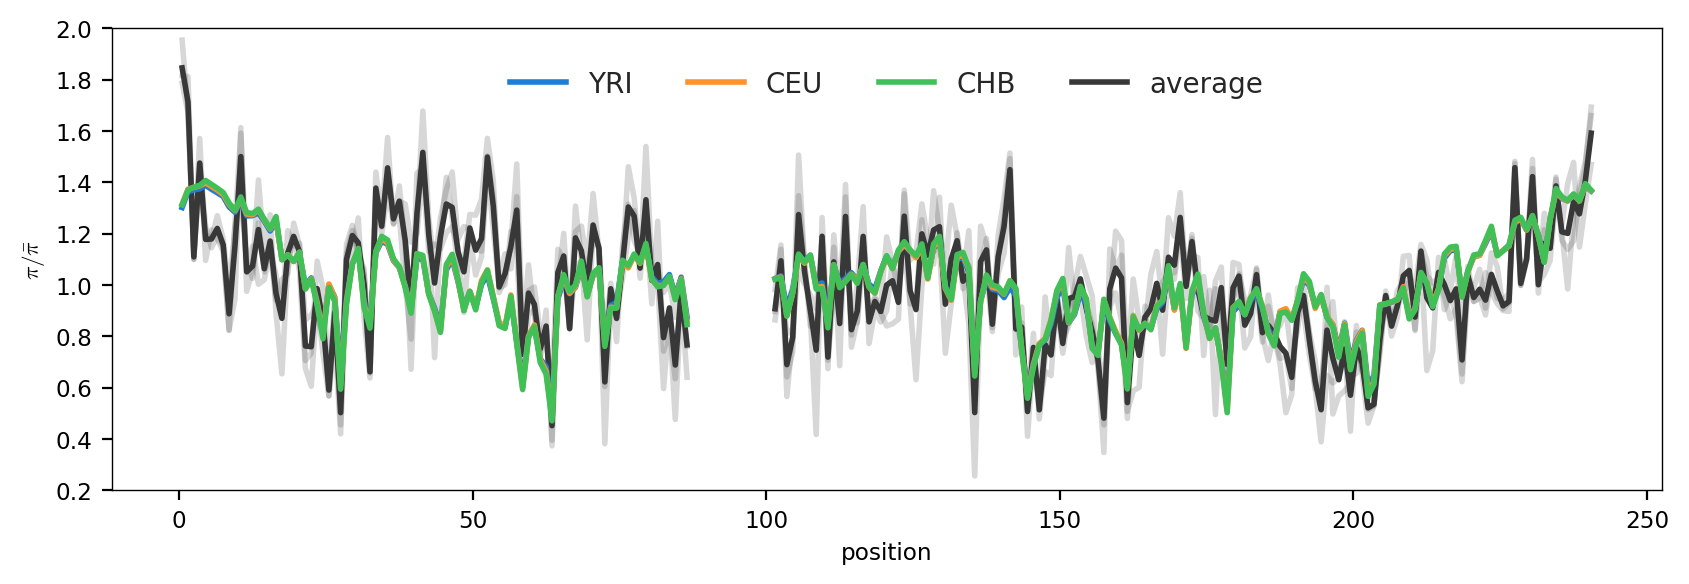

In [584]:
chrom = 'chr2'

def joint_prediction_plot(fits, chrom, pops=None, 
                          figax_kwargs=dict(figsize=(10, 3)), figax=None):
    if pops is None:
        pops = fits.keys()
    if isinstance(pops, str):
        pops = [pops]
    figax = get_figax(figax, **figax_kwargs)
    cols = sns.color_palette()
    fig, ax = figax
    pis = []
    for i, pop in enumerate(pops):
        fit = fits[pop]['mbp']
        midpoints, pi = fit.bins.pi_pairs(chrom)
        pis.append(pi)
        fit.predict_plot(chrom, figax=figax, pi_col='0.22', pred_col=cols[i], alpha_pi=0.2, label=pop.upper())

    ax.plot(to_mb(midpoints), mean_ratio(np.nanmean(np.stack(pis), axis=0)), c='0.22', label='average')
    old_handles, old_labels = ax.get_legend_handles_labels()

    handles, labels = [], []
    for h, l in zip(old_handles, old_labels):
        if l == 'data':
            continue
        h.set_linewidth(2)
        handles.append(h)
        labels.append(l)
    ax.legend(handles, labels, ncols=4, loc='upper center')
    return fig, ax

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_ylim(0.2, 2)
joint_prediction_plot(pcg, chrom, figax=(fig, ax))


#plt.savefig(f"../manuscript/figures/supplementary/talks/phastcons_model_fits_all.pdf")

In [470]:
{k: f['mbp'].R2() for k, f in pcg.items()}

{'yri': 0.6815821976013484,
 'ceu': 0.6301522801539102,
 'chb': 0.6108036144484064}

### CADD8

In [402]:
cd8 = dict()
cd8_full = dict()
cd8_rescale = dict()
for pop in pops:
    cd8[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl')
    cd8_full[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_full/mutrate_free/initial/mle.pkl')
    cd8_rescale[pop] = load_pickle(f'../new_fits/cadd8__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/rescaled/mle.pkl')

In [318]:
pop = 'yri'
cd8[pop]['mbp'], cd8_rescale[pop]['mbp']

(SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 250673972070.93787
 number of successful starts: 10000 (100.0% total)
 π0 = 0.00141668
 π  = 0.00106447
 μ_del  = 1.569e-08 
 Ne = 35,416 (if μ=1e-8), Ne = 17,708 (if μ=2e-8)
 R² = 67.0084% (in-sample)
 W = 
           cadd8
 ------  -------
 1e-08     0
 1e-07     0
 1e-06     0
 1e-05     0
 0.0001    0.059
 0.001     0.298
 0.01      0
 0.1       0.643,
 SimplexModel (interpolated w): 6 x 8 x 1
   w grid: [1.000e-11 6.310e-11 3.981e-10 2.512e-09 1.585e-08 1.000e-07] (before interpolation)
   t grid: [1.e-08 1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
   window size: 1.0 Mbp
 
 ML estimates: (whole genome)
 standard error method: None
 negative log-likelihood: 25064

Text(0.5, 0, 'predicted $B$')

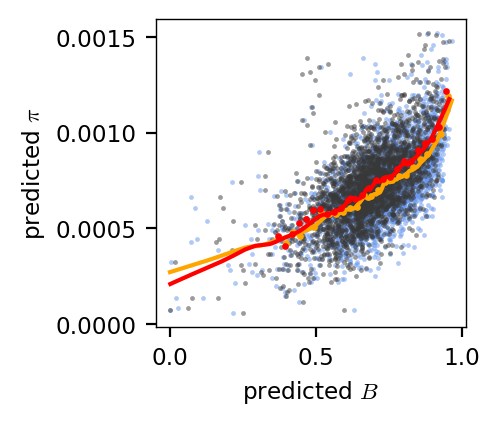

In [482]:
use_B = True
pop = 'chb'
fig, ax = plt.subplots(figsize=(2, 2))
predicted_observed(cd8[pop]['mbp'], figax=(fig, ax), use_B=use_B, c='cornflowerblue')
predicted_observed(cd8_rescale[pop]['mbp'], figax=(fig, ax), use_B=use_B, smooth_col='r', n_bins=40)
ax.set_ylabel('predicted $\pi$')
ax.set_xlabel('predicted $B$')
#ax.set_xlim((0.00025, 0.00105))
#ax.set_ylim((0.00019, 0.0016))

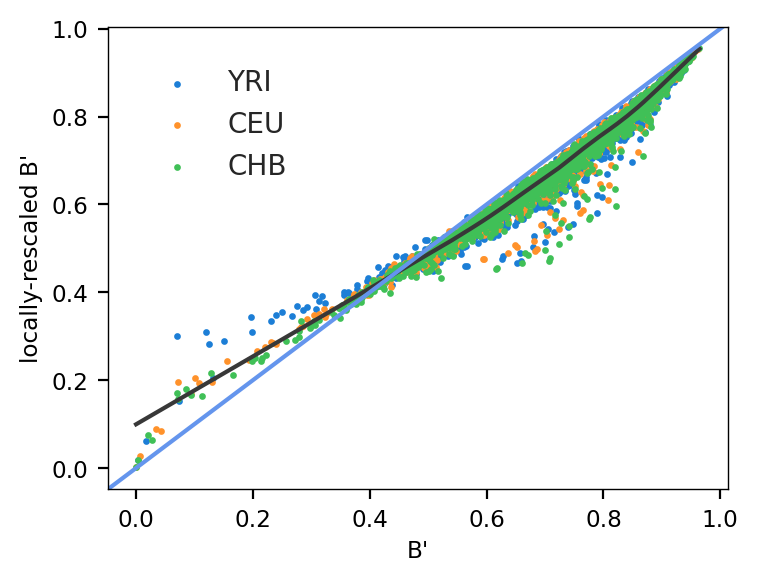

In [453]:
fig, ax = plt.subplots(figsize=(4, 3))
x, y = [], []
for pop in pops:
    ax.scatter(cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True), label=pop.upper(), s=2, alpha=1)
    x.extend(cd8[pop]['mbp'].predict(B=True))
    y.extend(cd8_rescale[pop]['mbp'].predict(B=True))


ax.plot(*smooth(x, y, frac=0.2), c='0.22')
ax.axline((0, 0), slope=1, c='cornflowerblue')
ax.set_ylabel("locally-rescaled B'")
ax.set_xlabel("B'")
ax.legend()

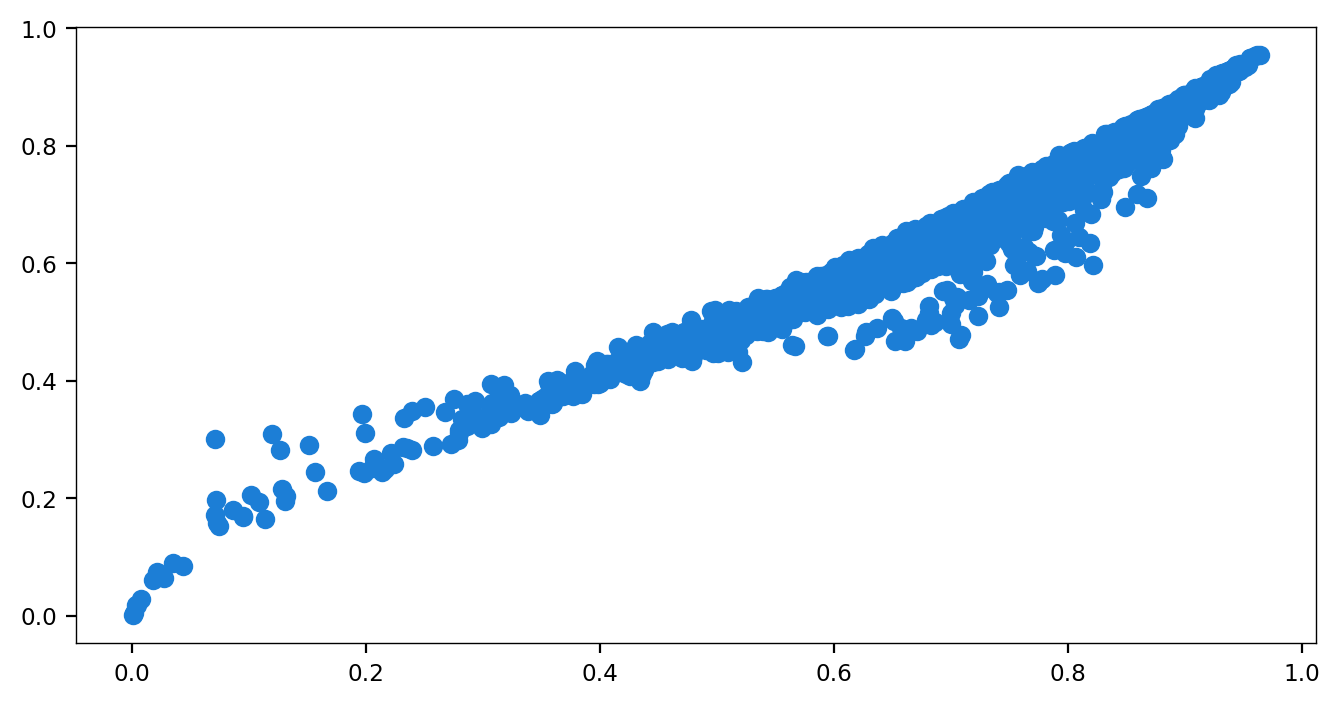

In [450]:
plt.scatter(x, y)

This change is interesting —  I think the HRI-type effects could be tipping the scales right around $Ns \approx 1$. 

First, things could be sensitive to my initial choice of neutral $N_e = 10,000$. What is the drift $N_e$ implied by this data?

In [395]:

for pop in pops:
    print((pop, cd8[pop]['mbp'].mle_pi0 / (4 * 1.3e-8)))

('yri', 27243.81489682956)
('ceu', 20587.968203528977)
('chb', 19345.549940170826)


So approximately, $20,000$ for bottlenecked pops, and ~27,000 for YRI.

Text(0.5, 0, '$B_r(x) - B(x)$')

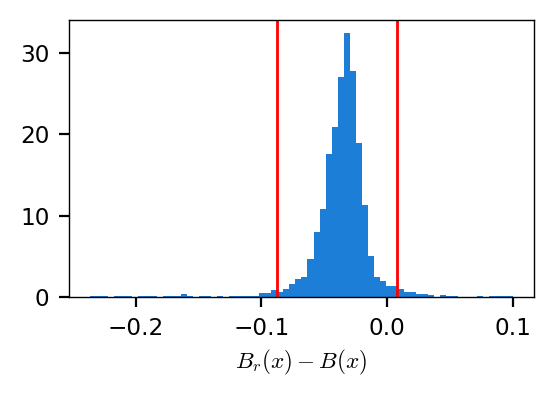

In [353]:
fig, ax = plt.subplots(figsize=(3, 1.8))
bins = cd8[pop]['mbp'].bins
b, br = cd8[pop]['mbp'].predict(B=True), cd8_rescale[pop]['mbp'].predict(B=True)
diff = br-b
_ = ax.hist(diff, 70, density=True)
cutoffs = np.quantile(diff, (0.02, 0.98))
ax.axvline(cutoffs[0], linewidth=1, c='r')
ax.axvline(cutoffs[1], linewidth=1, c='r')
ax.set_xlabel("$B_r(x) - B(x)$")

In [354]:
lower_idx = diff < cutoffs[0] 

In [361]:
#from bgspy.plots import predict_sparkplot
#predict_sparkplot(cd8[pop]['mbp'])

In [358]:
[bin for bin, keep in zip(bins.flat_bins(), lower_idx.tolist()) if keep]

[('chr1', 1000000, 2000000),
 ('chr1', 19000000, 20000000),
 ('chr1', 235000000, 236000000),
 ('chr2', 0, 1000000),
 ('chr2', 45000000, 46000000),
 ('chr2', 232000000, 233000000),
 ('chr3', 0, 1000000),
 ('chr4', 0, 1000000),
 ('chr4', 9000000, 10000000),
 ('chr5', 0, 1000000),
 ('chr5', 146000000, 147000000),
 ('chr5', 171000000, 172000000),
 ('chr5', 180000000, 181000000),
 ('chr6', 0, 1000000),
 ('chr7', 0, 1000000),
 ('chr7', 152000000, 153000000),
 ('chr8', 0, 1000000),
 ('chr8', 130000000, 131000000),
 ('chr8', 140000000, 141000000),
 ('chr9', 0, 1000000),
 ('chr9', 83000000, 84000000),
 ('chr10', 0, 1000000),
 ('chr11', 0, 1000000),
 ('chr11', 108000000, 109000000),
 ('chr11', 134000000, 135000000),
 ('chr12', 0, 1000000),
 ('chr12', 116000000, 117000000),
 ('chr12', 118000000, 119000000),
 ('chr12', 132000000, 133000000),
 ('chr13', 113000000, 114000000),
 ('chr14', 71000000, 72000000),
 ('chr15', 101000000, 101991189),
 ('chr16', 0, 1000000),
 ('chr16', 14000000, 15000000),
 (

### CADD6 

In [401]:
cd6 = dict()
for pop in pops:
    cd6[pop] = load_pickle(f'../new_fits/cadd6__decode/fits/pop_{pop}/window_1000000/type_sparse/mutrate_free/initial/mle.pkl') 

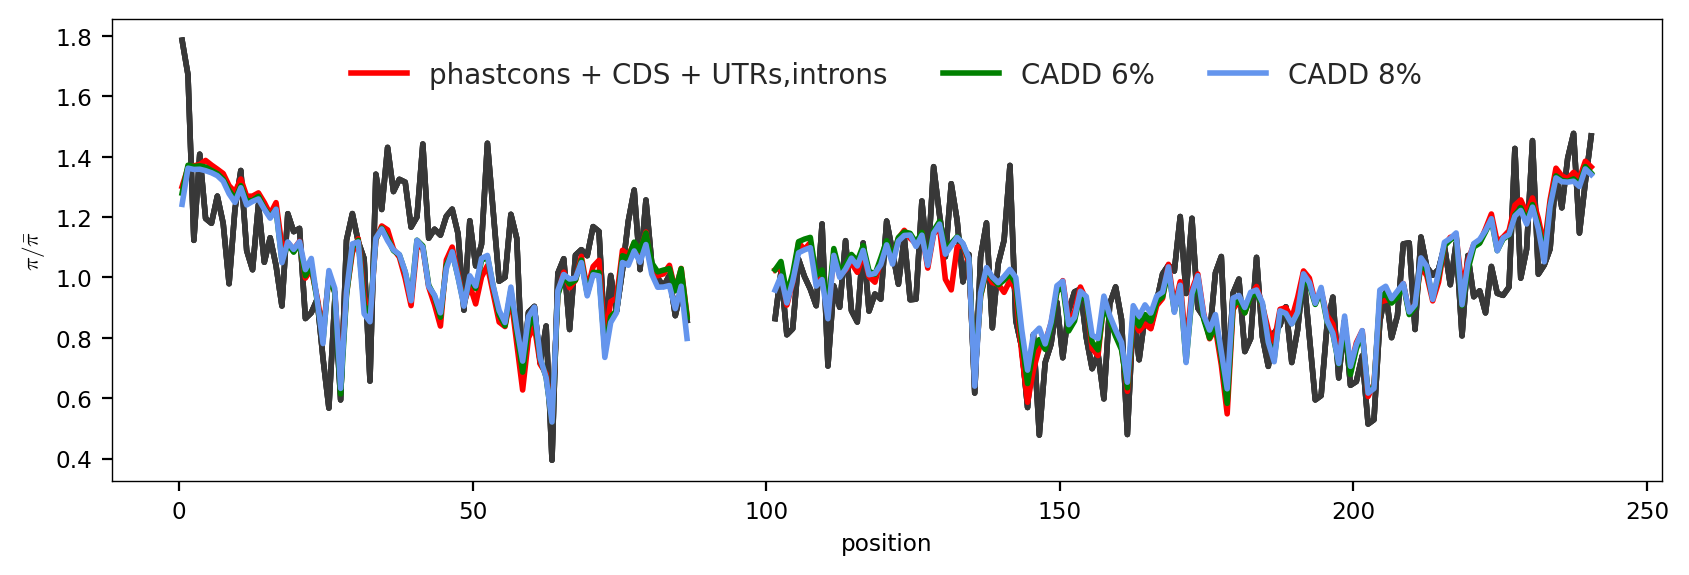

In [472]:
figax = plt.subplots(figsize=(10,3))
fig, ax = figax
pcg['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label='phastcons + CDS + UTRs,introns')
#pcg_full['yri']['mbp'].predict_plot('chr2', pred_col='orange', figax=figax, label='phastcons + CDS + UTRs,introns')
cd6['yri']['mbp'].predict_plot('chr2', pred_col='g', figax=figax, label='CADD 6%')
cd8['yri']['mbp'].predict_plot('chr2', figax=figax, label='CADD 8%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

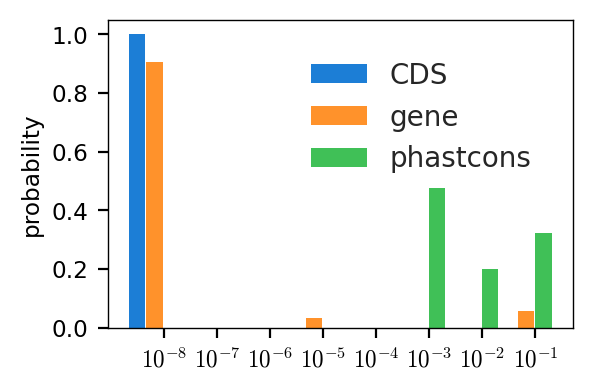

In [477]:
figax = plt.subplots(figsize=(3,2))
pcg['yri']['mbp'].dfe_plot(figax=figax)

In [478]:
def dfe_plot_alt(x_labels, groups, errors=None, keys=None, figax=None):
    fig, ax = get_figax(figax)
    nf = len(groups)
    x = np.arange(len(x_labels))
    
    width = 0.2  # the width of the bars
    mid_offset = -1
    multiplier = mid_offset

    bar_pos = []
    keys = groups.keys() if keys is None else keys
    for feature in keys:
        means = groups[feature]
        offset = width * multiplier
        pos = x + offset
        bar_pos.append(pos)
        rects = ax.bar(pos, means, width, label=feature.upper())
        if errors:
            ax.errorbar(pos, means, errors[feature], 
                        fmt='none', capsize=0, elinewidth=0.8, alpha=0.8, 
                        color='0.44')
        multiplier += 1
    
    ends = list(zip(bar_pos[0], bar_pos[-1]))    
    for i in range(len(x)):
        s, e = ends[i]
        #ax.plot((s-width/2, e+ width/2), (0, 0), c='k')

    #ax.spines['top'].set_visible(False)
    #ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    ax.set_xticks(x + width, x_labels)
    ax.set_ylim(-0.001, None)
    

TypeError: unsupported operand type(s) for +: 'int' and 'SimplexModel'

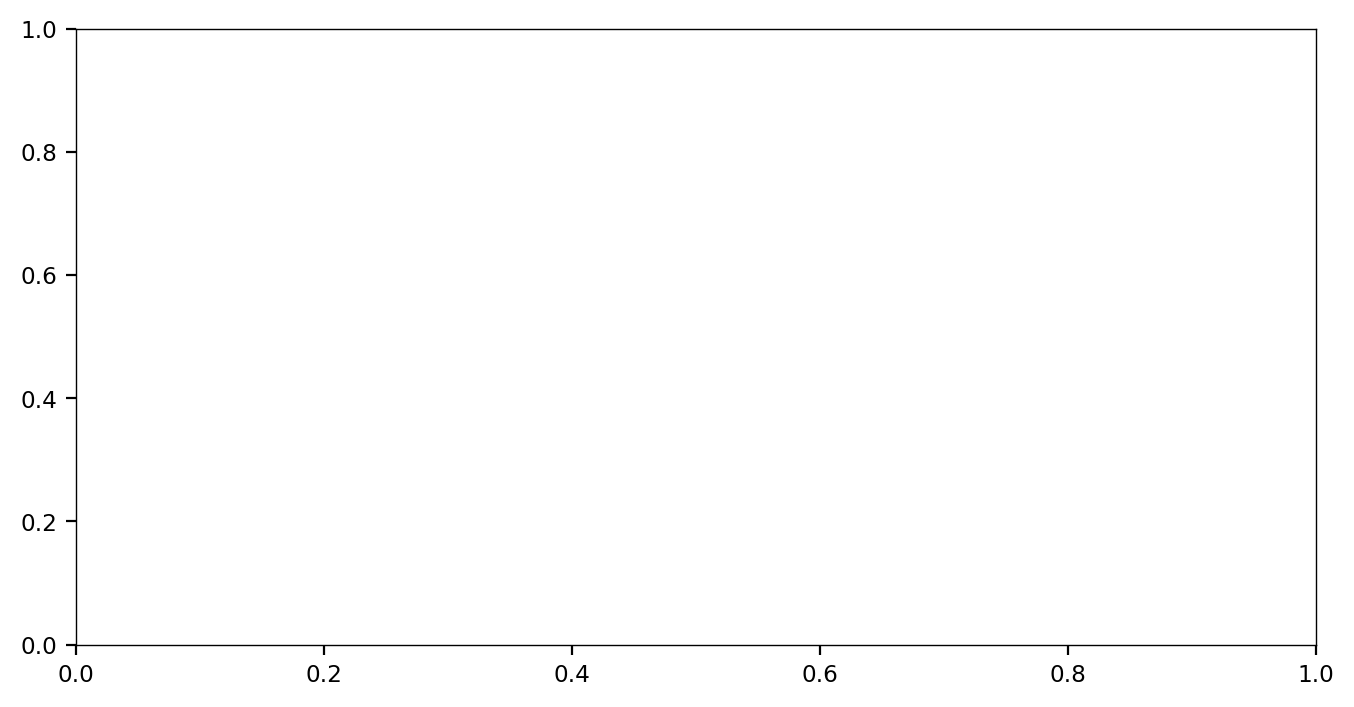

In [480]:
dfe_plot_alt(pcg['yri']['mbp'].t, {k: v['mbp'] for k, v in pcg.items()})

In [ ]:
dfes = defaultdict(lambda: defaultdict(dict))
dfe_errors = defaultdict(lambda: defaultdict(dict))

for model in fits:
    for pop in fits[model]:
        fit = fits[model][pop]
        res = fit.W_stderrs()
        if res is None:
            continue
        means, errors = res
        for feature in means:
            dfes[model][feature][pop] = means[feature]
            dfe_errors[model][feature][pop] = errors[feature]

In [ ]:
from bgspy.plots import get_figax

fit = fits['full-hapmap']['ceu']
means, errors = fit.W_stderrs()




fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(3, 4), sharex=True,)

feature_labels = {'phastcons': 'phastcons', 'cds': 'coding', 'gene':'introns+UTRs', 'other':'other'}
features = dfes['full-hapmap']
for i, feature in enumerate(feature_labels.keys()):
    dfe_plot_alt(np.arange(-8, 0), 
                 dfes['full-hapmap'][feature], 
                 errors=dfe_errors['full-hapmap'][feature],
                 figax=(fig, ax[i]))
    ax[i].text(0.5, 0.8, feature_labels[feature], transform=ax[i].transAxes, ha='center', fontsize=8)
    ax[i].set_ylim(0, 1.1)
    ax[i].set_yticks((0.0, 0.5, 1.0), (0, 0.5, 1), fontsize=6)
    if i < 3:
        ax[i].xaxis.set_ticks_position('none') 
    
ax[3].legend(ncols=1, prop={'size': 6})
fig.subplots_adjust(wspace=0, hspace=0.1)
ts = np.arange(-8, 0)
ax[3].set_xticks(range(len(ts)), [f"$10^{{{f}}}$" for f in ts], fontsize=6)

(<Figure size 1600x800 with 1 Axes>,
 <Axes: xlabel='predicted $\\hat{\\pi}$', ylabel='residuals'>)

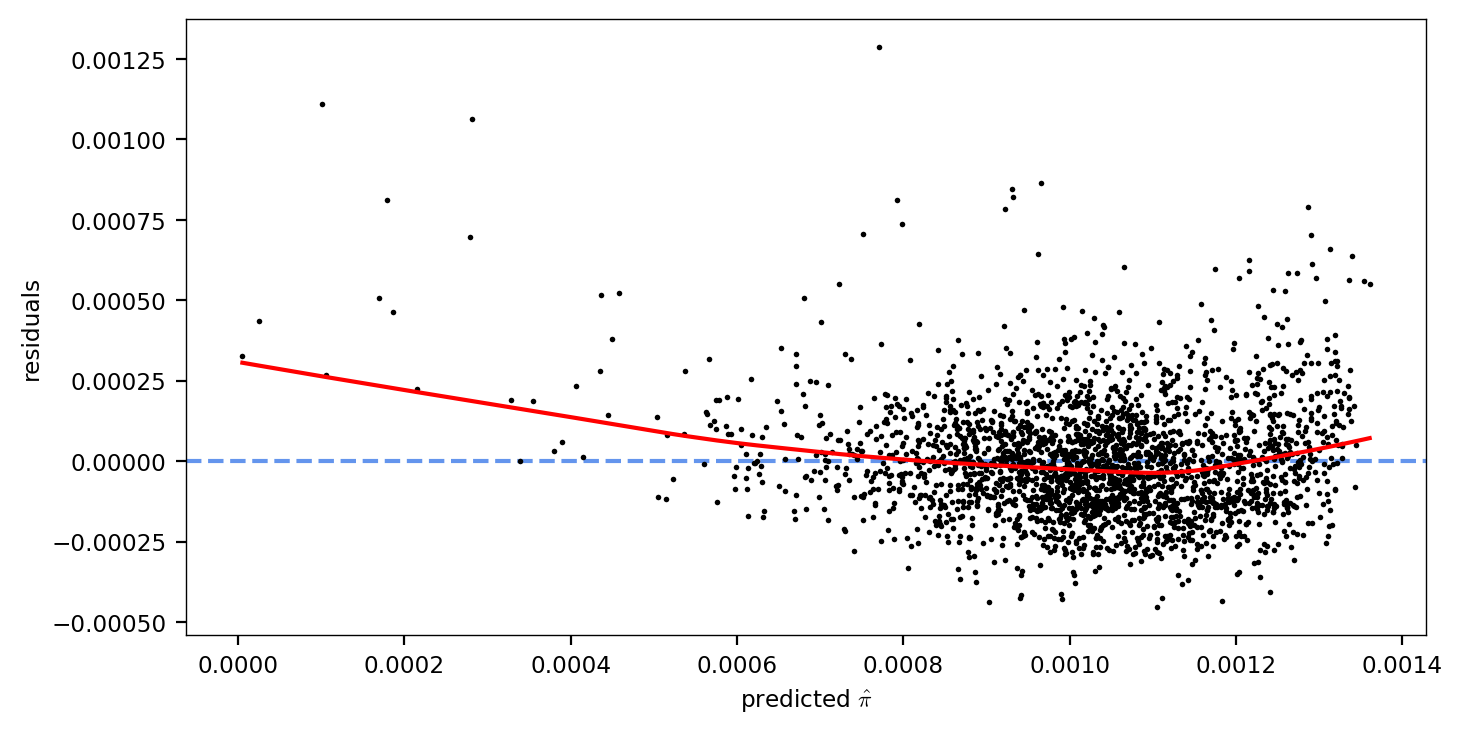

In [161]:
cd8['yri']['mbp'].resid_fitted_plot(color=False)


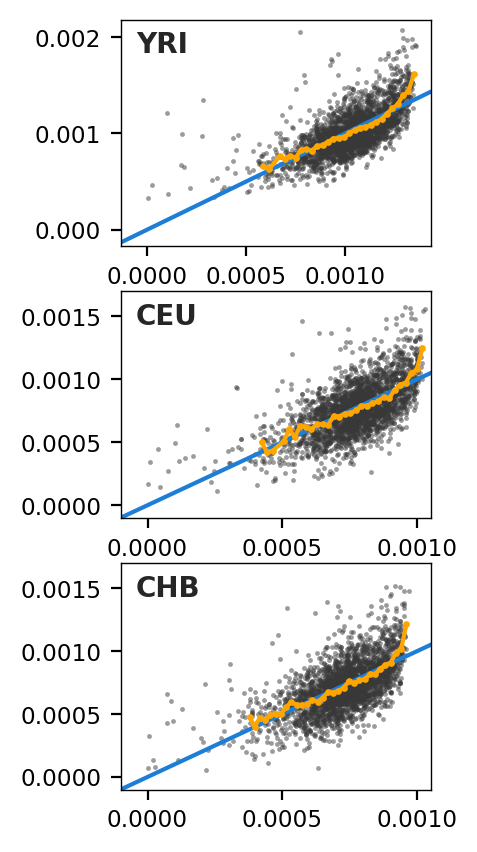

In [249]:
equal_num = False
smooth_col = 'orange'

fig, ax = plt.subplots(ncols=1, nrows=3, figsize=(2, 5))# sharex=True, sharey=True)
for i, pop in enumerate(pops):
    predicted_observed(cd8[pop]['mbp'], figax=(fig, ax[i])) 
    ax[i].text(0.05, 0.95, pop.upper(), transform=ax[i].transAxes, 
               fontsize=10, fontweight='bold', va='top')
    if i >= 1:
        ax[i].set_xlim((-1e-4, 0.00105))
        ax[i].set_ylim((-1e-4, 0.0017))

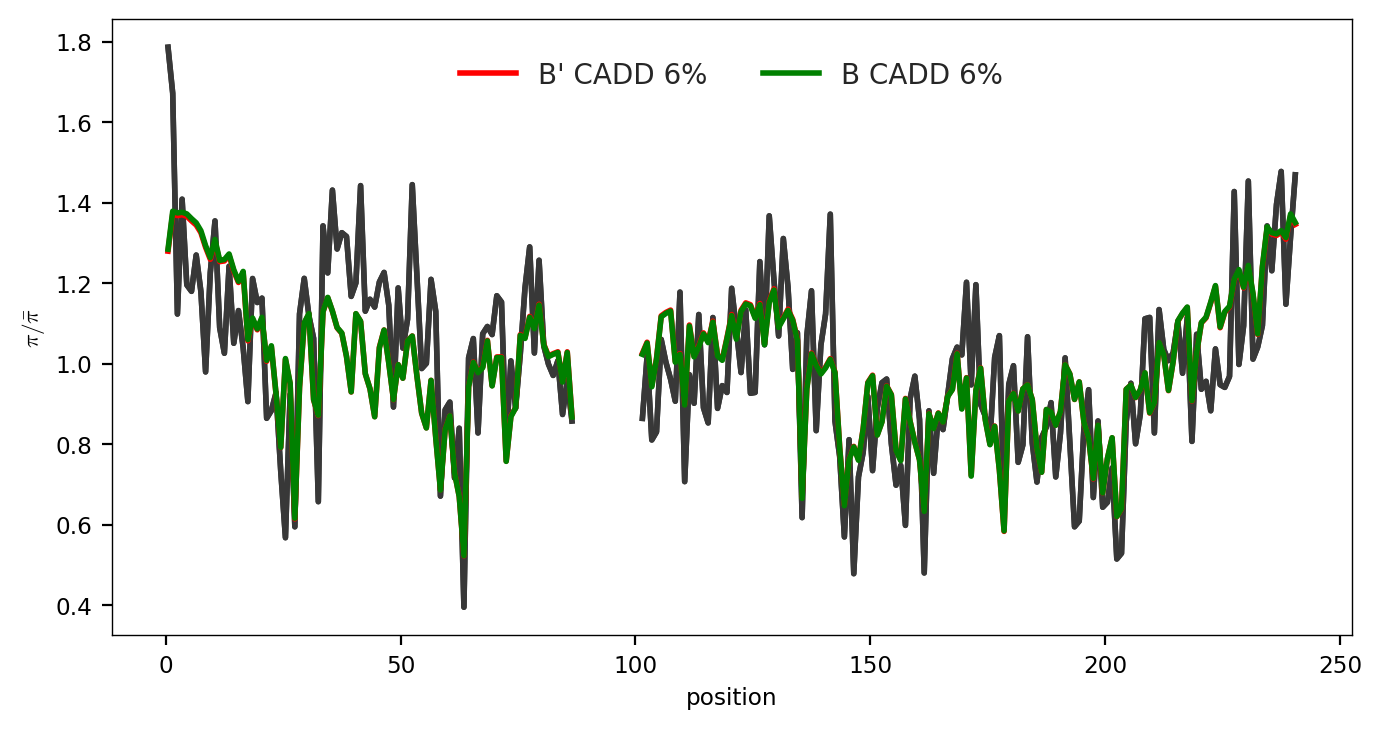

In [392]:
figax = plt.subplots()
fig, ax = figax
cd6['yri']['mbp'].predict_plot('chr2', pred_col='r', figax=figax, label="B' CADD 6%")
cd6['yri']['mb'].predict_plot('chr2', pred_col='g', figax=figax, label='B CADD 6%')
ax.legend(ncols=3)

old_handles, old_labels = ax.get_legend_handles_labels()

handles, labels = [], []
for h, l in zip(old_handles, old_labels):
    if l == 'data':
        continue
    h.set_linewidth(2)
    handles.append(h)
    labels.append(l)
ax.legend(handles, labels, ncols=4, loc='upper center')

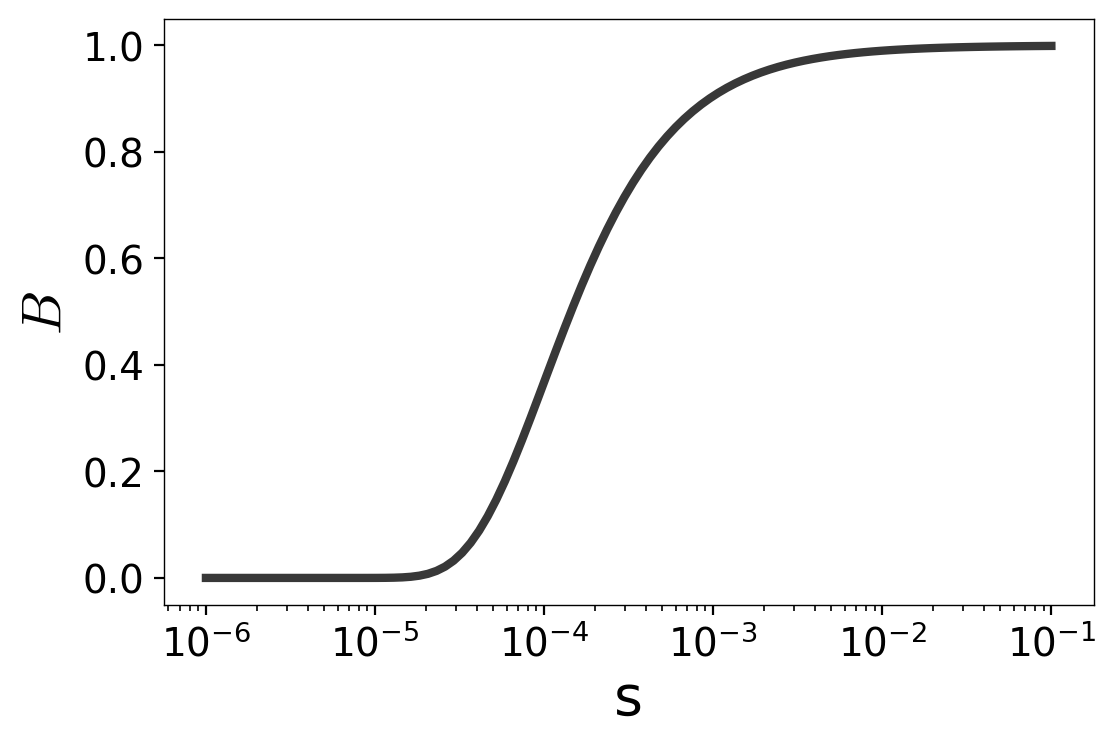

In [443]:
def bgs(s, u):
    return np.exp(-u/s)

fig, ax = plt.subplots(figsize=(6,3.8))
s = np.logspace(-6, -1, 100)
ax.plot(s, bgs(s, 1e-4), c='0.22', linewidth=3)
ax.semilogx()
ax.set_ylabel("$B$", fontsize=20)
ax.set_xlabel("s", fontsize=20) 
ax.tick_params(axis='both', which='major', labelsize=14)


In [425]:
np.exp(- 0.5 / s[-10:])

array([6.53986360e-07, 3.12266901e-06, 1.25586787e-05, 4.33516838e-05,
       1.30616156e-04, 3.48659775e-04, 8.35591405e-04, 1.81933466e-03,
       3.63691252e-03, 6.73794700e-03])

In [422]:
s

array([1.00000000e-06, 1.12332403e-06, 1.26185688e-06, 1.41747416e-06,
       1.59228279e-06, 1.78864953e-06, 2.00923300e-06, 2.25701972e-06,
       2.53536449e-06, 2.84803587e-06, 3.19926714e-06, 3.59381366e-06,
       4.03701726e-06, 4.53487851e-06, 5.09413801e-06, 5.72236766e-06,
       6.42807312e-06, 7.22080902e-06, 8.11130831e-06, 9.11162756e-06,
       1.02353102e-05, 1.14975700e-05, 1.29154967e-05, 1.45082878e-05,
       1.62975083e-05, 1.83073828e-05, 2.05651231e-05, 2.31012970e-05,
       2.59502421e-05, 2.91505306e-05, 3.27454916e-05, 3.67837977e-05,
       4.13201240e-05, 4.64158883e-05, 5.21400829e-05, 5.85702082e-05,
       6.57933225e-05, 7.39072203e-05, 8.30217568e-05, 9.32603347e-05,
       1.04761575e-04, 1.17681195e-04, 1.32194115e-04, 1.48496826e-04,
       1.66810054e-04, 1.87381742e-04, 2.10490414e-04, 2.36448941e-04,
       2.65608778e-04, 2.98364724e-04, 3.35160265e-04, 3.76493581e-04,
       4.22924287e-04, 4.75081016e-04, 5.33669923e-04, 5.99484250e-04,
      